# TD3 : Let's play with faces
## Part 2 - Transfert Learning (Train classifier)

S. Delprat, INSA Hauts-de-France

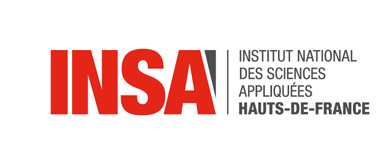


We are now going to train a new classification head from the embedding that are stored on a file.  
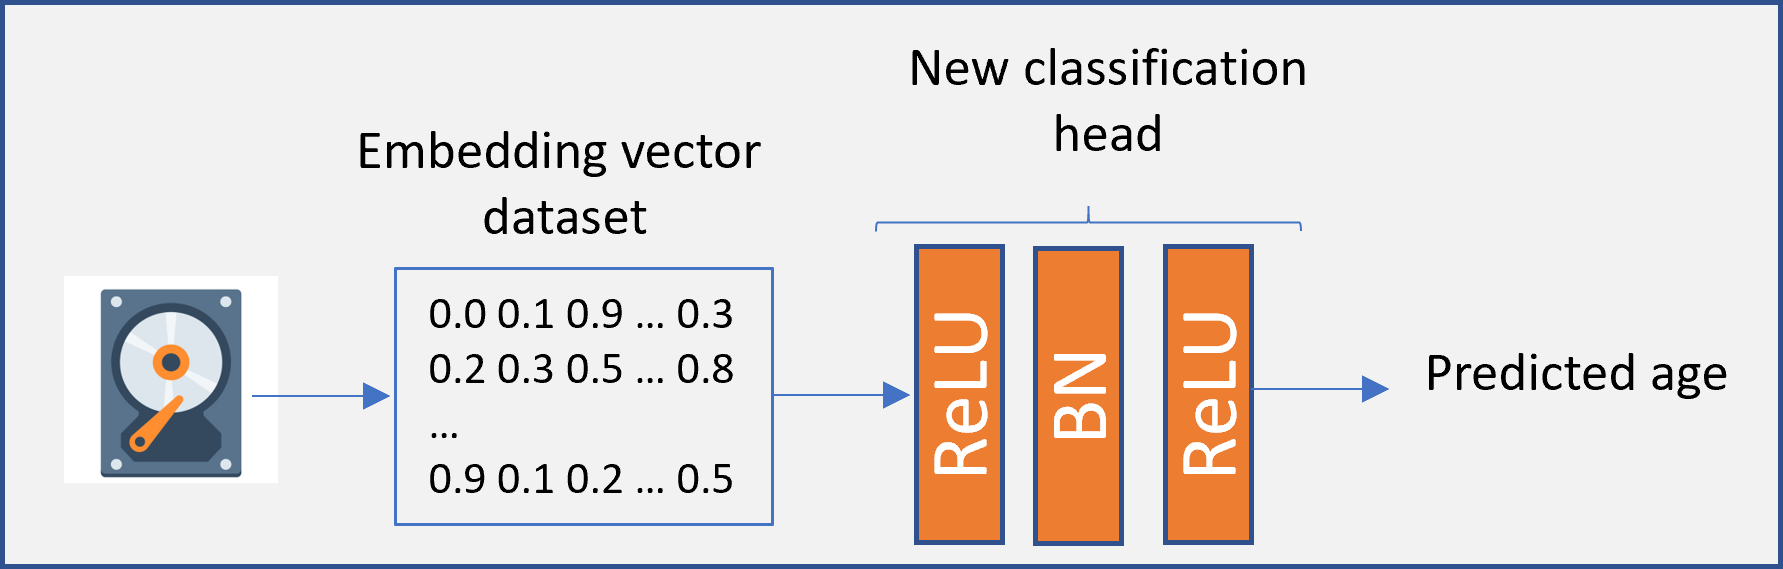

# Definitions

In [2]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import os
import pickle

*Q1.* Mount google drive and defines the path to the binary file containing your data

In [3]:
binaryEmbeddingFile='../models/td3/result/Part1/embedding.bin'

# Check if the file exists
if not os.path.exists(binaryEmbeddingFile):
    raise Exception(f"File {binaryEmbeddingFile} not found")
else :
    print(f"Embedding file found: {binaryEmbeddingFile}")

Embedding file found: ../models/td3/result/Part1/embedding.bin


Random seed

In [4]:
DEFAULT_RANDOM_SEED=42
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + tensorflow + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

Configuration of the hyperparameters

*Q2.* Chose a batchsize  
What is the size of the embedding vector ?
=> explain the your choice in a Text cell below

The last three layers of the original mtcnn were :
```
├─Dropout (dropout)                           [32, 1792, 1, 1]     [32, 1792, 1, 1]     --                   --
├─Linear (last_linear)                        [32, 1792]           [32, 512]            917,504              True
├─BatchNorm1d (last_bn)                       [32, 512]            [32, 512]            1,024                True
```
We removed the Linear and BatchNorm1d layers to keep only the backbone.
So the output of the backbone is a tensor of shape `[32, 1792]`, `32` being the batch size and `1792` the size of the embedding vector.

In [5]:
experimentName                          = "Part2"
maxImgsTrain, maxImgsValid, maxImgsTest = None, None, None
batchSize                               = 1024
learningRate                            = 0.001
numEpoch                                = 100        # number of epoch for the training
resultFolder                            =  os.path.join("../models/td3/result", experimentName)
dataFolder                              = '../data/processed/UTKFace'

In [6]:
if not os.path.isdir(resultFolder):
    os.makedirs(resultFolder)

Check cuda availability (if not available, please select GPU P100 as an accelerator and NOT the dual T4)

In [7]:
torch.__version__

'2.2.2+cu121'

In [8]:
if torch.cuda.is_available():
  print('cuda is available')
  device='cuda'
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

    device_cap = torch.cuda.get_device_capability()
    print('device capability : ',torch.cuda.get_device_capability())
else:
  print('cuda is not available')
  device='cpu'

cuda is available
NVIDIA GeForce GTX 1050
device capability :  (6, 1)


# Load embeddings

*Q3.*: load the pickle file <code>binaryEmbeddingFile</code>

In [9]:
# Load the embeddings and labels from the file
with open(binaryEmbeddingFile, 'rb') as f:
    train_embeddings, train_ages, train_kept_indices, valid_embeddings, valid_ages, valid_kept_indices, test_embeddings, test_ages, test_kept_indices = pickle.load(f)

# Check the shapes and types
print(f"Train embeddings: {train_embeddings.shape}, Train ages: {train_ages.shape}")
print(f"Valid embeddings: {valid_embeddings.shape}, Valid ages: {valid_ages.shape}")
print(f"Test embeddings: {test_embeddings.shape}, Test ages: {test_ages.shape}")
print(f"Embedding data type: {train_embeddings.dtype}")

Train embeddings: torch.Size([15988, 1792]), Train ages: torch.Size([15988])
Valid embeddings: torch.Size([3443, 1792]), Valid ages: torch.Size([3443])
Test embeddings: torch.Size([3440, 1792]), Test ages: torch.Size([3440])
Embedding data type: torch.float32


*Q4.* create a dataset that outputs the embedding, the perceived age and the filename  
The embedding vector & the perceived age should be <code>float32</code> tensor

In [10]:
# Create a dataset that outputs the embedding, the perceived age and the filename  
# The embedding vector & the perceived age should be float32 tensor
from torch.utils.data import Dataset

class embeddingDataset(torch.utils.data.Dataset):
  def __init__(self, embeddings, perceivedAges, fileNames):
    self.embeddings = embeddings.clone().detach()
    self.perceivedAges = perceivedAges.clone().detach()
    self.fileNames = fileNames

    assert len(self.embeddings) == len(self.perceivedAges)
    assert len(self.embeddings) == len(self.fileNames)

  def __len__(self):
    return len(self.embeddings)

  def __getitem__(self, idx):
    return self.embeddings[idx], self.perceivedAges[idx], self.fileNames[idx]

*Q5.* creeate 3 datasets for training, validation and testing along with the 3 corresponding dataloaders

In [11]:
# Get all filenames from original dataset structure
from glob import glob
import os

# Get filenames for each split
train_files = sorted(glob(os.path.join(dataFolder, 'train', '*.jpg')))
valid_files = sorted(glob(os.path.join(dataFolder, 'validation', '*.jpg')))
test_files = sorted(glob(os.path.join(dataFolder, 'test', '*.jpg')))

# Use kept_indices to get the correct filenames
train_filenames = [train_files[i] for i in train_kept_indices if i < len(train_files)]
valid_filenames = [valid_files[i] for i in valid_kept_indices if i < len(valid_files)]
test_filenames = [test_files[i] for i in test_kept_indices if i < len(test_files)]

# And use them in the dataset
train_dataset = embeddingDataset(train_embeddings, train_ages, train_filenames)
valid_dataset = embeddingDataset(valid_embeddings, valid_ages, valid_filenames)
test_dataset = embeddingDataset(test_embeddings, test_ages, test_filenames)

# Create the dataloaders with appropriate batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

# Print the number of batches
print(f"Number of batches - Train: {len(train_loader)}, Valid: {len(valid_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 16, Valid: 4, Test: 4


# Define a model for the classification head

*Q6.* Create the <code>myClassificationHead</code> used to predict the age from the embedding vector.

Do not use any convolutional layer... it is just a prediction head


In [12]:
# Create the myClassificationHead used to predict the age from the embedding vector.

# Do not use any convolutional layer... it is just a prediction head
class myClassificationHead(torch.nn.Module):
    def __init__(self, nFeat):
        super(myClassificationHead, self).__init__()
        self.fc1 = torch.nn.Linear(nFeat, 64)
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


*Q7.* Create one instance of myClassificationHead

In [13]:
# Create one instance of myClassificationHead
nFeat = train_embeddings.shape[1]  # Get the embedding dimension
classificationHead = myClassificationHead(nFeat).to(device)
print(f"Created classification head with input dimension: {nFeat}")

Created classification head with input dimension: 1792


# Training loop

*Q6.* Define the optimizer & the criterion  
If the model is not of the <code>device</code>, send it!

What are the possible criterion for the considered task. Why? Provide you answer in the text cell below

**Explain the possible criterion here**

In [14]:
# Define the optimizer & the criterion  
# If the model is not of the device, send it!
optimizer = torch.optim.Adam(classificationHead.parameters(), lr=learningRate)
criterion = torch.nn.L1Loss()
# We will send the model to device during training

# L1Loss (Mean Absolute Error) is a good choice for age prediction because:
# - It measures the average absolute difference between predictions and targets
# - It's less sensitive to outliers than MSE // It's more robust when data might have noise or incorrect labels
# - The error is in the same units as the target (years), making it interpretable

*Q7.* Program a training loop  
You may adapt the code fromt he previous exercise session

In [15]:
history = {"train_loss": [],
           "train_rmse": [],
           "train_x": [],
           "val_loss": [],
           "val_rmse": [],
           "val_x":[]
  }
bestValidationLoss=math.inf

NB: to store a copy of an existing model, you must use <code>modele2 = copy.deepcopy(modele1)</code>  
The code <code>modele2=modele1</code> simply create a reference of <code>modele1</code> (i.e. modifying <code>modele1</code> will also modify <code>modele2</code>!)


In [16]:
# Training loop
for epoch in range(numEpoch):
    # Training phase
    classificationHead.train()
    train_loss = 0.0
    train_rmse = 0.0
    num_train_batches = 0

    for embeddings, ages, _ in train_loader:
        embeddings, ages = embeddings.to(device), ages.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classificationHead(embeddings)
        loss = criterion(outputs.squeeze(), ages)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Calculate metrics
        train_loss += loss.item() * embeddings.size(0)
        train_rmse += torch.sqrt(torch.mean((outputs.squeeze() - ages) ** 2)).item() * embeddings.size(0)
        num_train_batches += 1

    # Calculate average metrics
    train_loss /= len(train_dataset)
    train_rmse /= len(train_dataset)
    history["train_loss"].append(train_loss)
    history["train_rmse"].append(train_rmse)
    history["train_x"].append(epoch)

    # Validation phase
    classificationHead.eval()
    val_loss = 0.0
    val_rmse = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for embeddings, ages, _ in valid_loader:
            embeddings, ages = embeddings.to(device), ages.to(device)

            # Forward pass
            outputs = classificationHead(embeddings)
            loss = criterion(outputs.squeeze(), ages)

            # Calculate metrics
            val_loss += loss.item() * embeddings.size(0)
            val_rmse += torch.sqrt(torch.mean((outputs.squeeze() - ages) ** 2)).item() * embeddings.size(0)
            num_val_batches += 1

    # Calculate average metrics
    val_loss /= len(valid_dataset)
    val_rmse /= len(valid_dataset)
    history["val_loss"].append(val_loss)
    history["val_rmse"].append(val_rmse)
    history["val_x"].append(epoch)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{numEpoch}, Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')

    # Save the best model
    if val_loss < bestValidationLoss:
        bestValidationLoss = val_loss
        torch.save(classificationHead.state_dict(), os.path.join(resultFolder, "bestModel.pth"))
        print(f"Saved best model with validation loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 33.6135, Train RMSE: 38.8172, Val Loss: 33.4635, Val RMSE: 38.8612
Saved best model with validation loss: 33.4635
Epoch 2/100, Train Loss: 33.1934, Train RMSE: 38.4986, Val Loss: 32.9836, Val RMSE: 38.4705
Saved best model with validation loss: 32.9836
Epoch 3/100, Train Loss: 32.6608, Train RMSE: 38.0344, Val Loss: 32.3744, Val RMSE: 37.9248
Saved best model with validation loss: 32.3744
Epoch 4/100, Train Loss: 31.9734, Train RMSE: 37.4108, Val Loss: 31.5857, Val RMSE: 37.2052
Saved best model with validation loss: 31.5857
Epoch 5/100, Train Loss: 31.0984, Train RMSE: 36.6045, Val Loss: 30.6110, Val RMSE: 36.3069
Saved best model with validation loss: 30.6110
Epoch 6/100, Train Loss: 30.0280, Train RMSE: 35.6104, Val Loss: 29.4340, Val RMSE: 35.2315
Saved best model with validation loss: 29.4340
Epoch 7/100, Train Loss: 28.7512, Train RMSE: 34.4603, Val Loss: 28.0661, Val RMSE: 34.0022
Saved best model with validation loss: 28.0661
Epoch 8/100, Train Loss: 27

*Q8.* Save the obtained model

In [17]:
# Save the final model
final_model_path = os.path.join(resultFolder, "finalModel.pth")
torch.save(classificationHead.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")

Saved final model to ../models/td3/result/Part2/finalModel.pth


*Q9.* Plot training curves & save them to "trainingCurves.png"

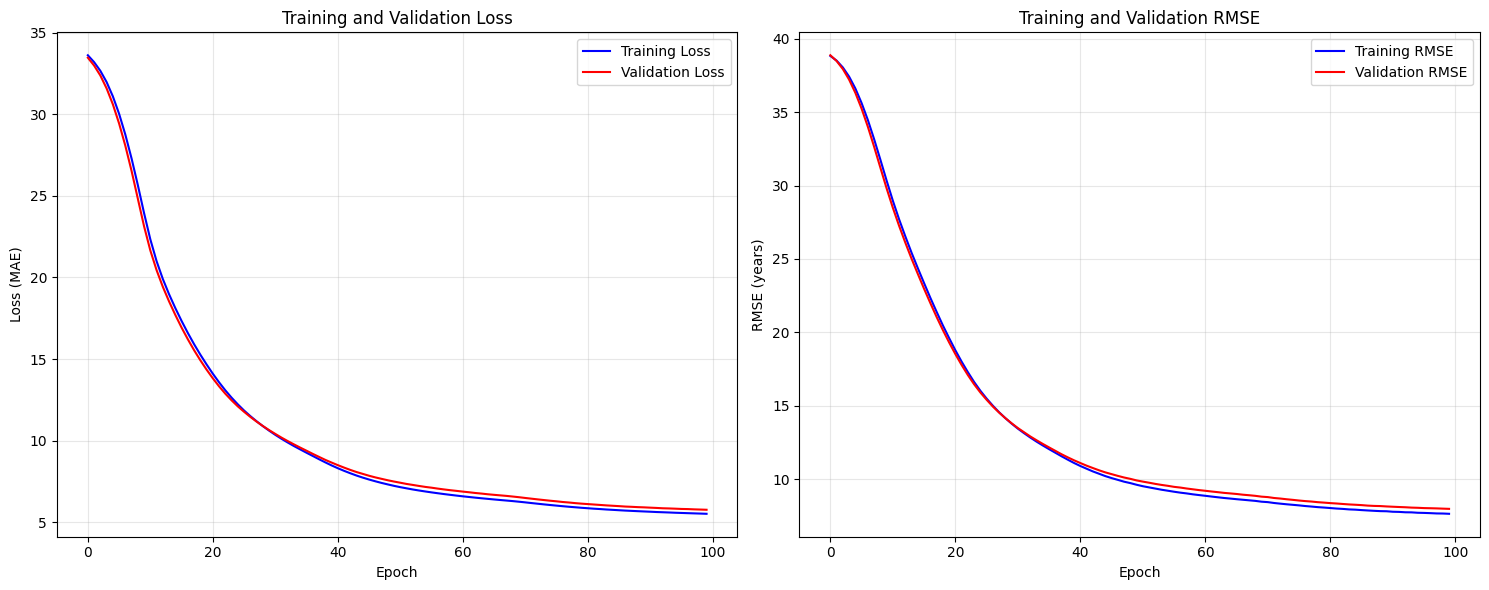

Saved training curves to ../models/td3/result/Part2/trainingCurves.png


In [18]:
# Plot training curves
plt.figure(figsize=(15, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history["train_x"], history["train_loss"], 'b-', label='Training Loss')
plt.plot(history["val_x"], history["val_loss"], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE curve
plt.subplot(1, 2, 2)
plt.plot(history["train_x"], history["train_rmse"], 'b-', label='Training RMSE')
plt.plot(history["val_x"], history["val_rmse"], 'r-', label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (years)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
curves_path = os.path.join(resultFolder, "trainingCurves.png")
plt.savefig(curves_path)
plt.show()
print(f"Saved training curves to {curves_path}")

The training curves show a rapid initial decrease in both loss and RMSE, followed by a gradual flattening. Several observations:

1. Convergence Speed: The model converges rapidly within the first 80 epochs, with diminishing improvements afterward. The curves suggest we could potentially benefit from training longer with a reduced learning rate on more epochs to achieve better results, as we haven't reached a definitive plateau.
2. Gap Between Training and Validation: There's a small but consistent gap between training and validation performance. The data distribution may not be optimal.
3. Validation Stability: The validation loss shows minor fluctuations but remains relatively stable, suggesting the model generalizes well to unseen data.

# Test result analysis

*Q10.* Predict data over the test dataset  
Do not forget to use the best  model obtained during training
The outcome are 2 python list <code>allYtest</code> and <code>allYtrue</code> that contains the predicted age and the real ground thrue value

In [19]:
# Load the best model for evaluation
best_model_path = os.path.join(resultFolder, "bestModel.pth")
classificationHead.load_state_dict(torch.load(best_model_path))
classificationHead.eval()
print(f"Loaded best model from {best_model_path}")

# Predict on test set
allYtest = []
allYtrue = []

with torch.no_grad():
    for embeddings, ages, _ in test_loader:
        embeddings, ages = embeddings.to(device), ages.to(device)
        outputs = classificationHead(embeddings)
        allYtest.extend(outputs.squeeze().cpu().numpy())
        allYtrue.extend(ages.cpu().numpy())

# Convert to numpy arrays
allYtest = np.array(allYtest)
allYtrue = np.array(allYtrue)

Loaded best model from ../models/td3/result/Part2/bestModel.pth


*Q11.* Compute the prediction error and display its RMSE value

In [20]:
# Compute the prediction error and RMSE
error = allYtest - allYtrue
test_rmse = np.sqrt(np.mean(error**2))
test_mae = np.mean(np.abs(error))
print(f'Test Results - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}')

Test Results - RMSE: 7.8806, MAE: 5.6909


*Q12.* Display predicted age vs real age and error distribution

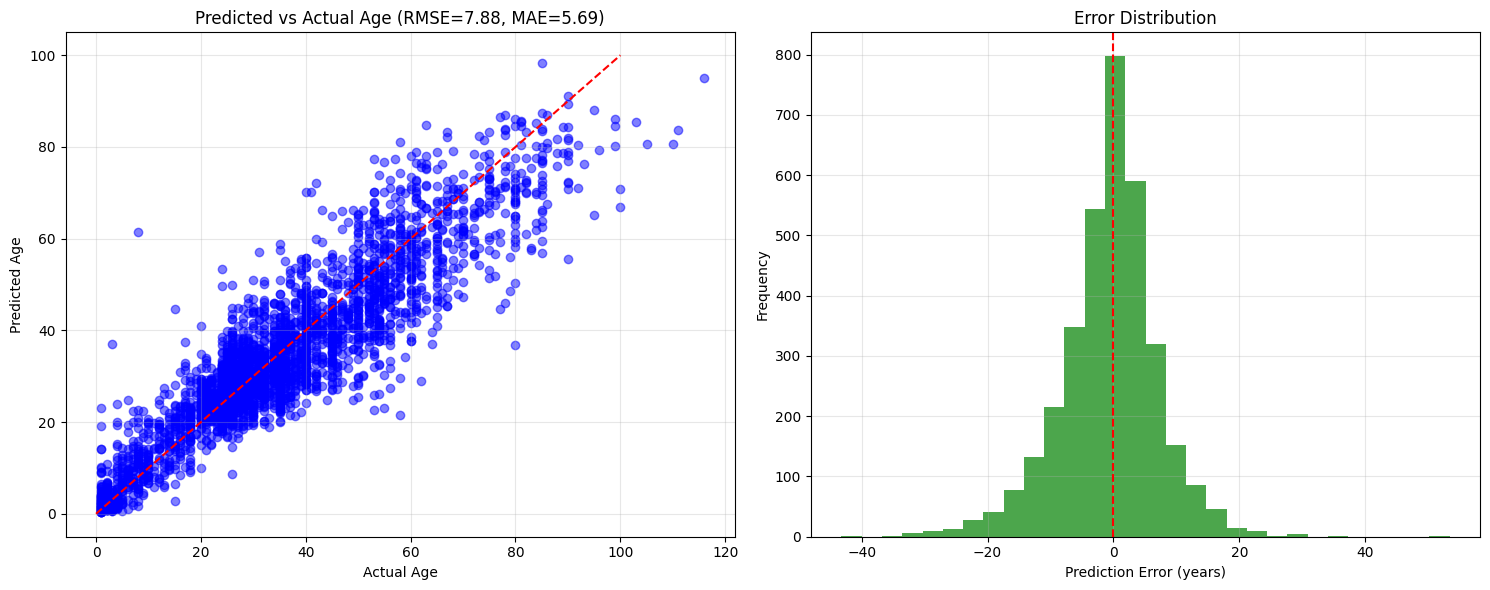

Saved test results visualization to ../models/td3/result/Part2/testResults.png


In [21]:
# Visualize predicted vs actual age and error distribution
plt.figure(figsize=(15, 6))

# Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(allYtrue, allYtest, alpha=0.5, color='blue')
plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title(f'Predicted vs Actual Age (RMSE={test_rmse:.2f}, MAE={test_mae:.2f})')
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 2, 2)
plt.hist(error, bins=30, alpha=0.7, color='green')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error (years)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
results_path = os.path.join(resultFolder, "testResults.png")
plt.savefig(results_path)
plt.show()
print(f"Saved test results visualization to {results_path}")

The scatter plot and error distribution reveal key insights about our age prediction model:

- Prediction Accuracy: With a MAE of approximately 5.7 years and RMSE of around 7.9 years, our model achieves reasonable accuracy for age prediction from facial embeddings.

- Error Distribution: The error histogram shows that:
    - Errors are reasonably symmetric around zero, indicating no systematic bias toward under or over-prediction
    - Most predictions fall within ±10 years of actual age
    - The distribution is slightly leptokurtic (https://statisticsbyjim.com/basics/kurtosis/), with a concentration of small errors and some outliers


- Age-Dependent Performance: The scatter plot reveals that:

    - Prediction accuracy decreases for older individuals (greater spread away from the perfect prediction line)
    - The model tends to underestimate ages for very old individuals and occasionally overestimate for very young individuals
    - Middle-aged predictions (20-40 years) show greater consistency


- Potential Limitations: Several factors might contribute to prediction errors:

    - Unbalanced training data with fewer examples of older individuals
    - Inherent difficulty in distinguishing specific ages within similar age groups
    - Variation in aging patterns across different demographics
    - Image quality and face detection/alignment issues

### More experiments


Training Baseline...
Epoch 10/100, Train Loss: 23.8885, Val Loss: 23.0975
Epoch 20/100, Train Loss: 14.8994, Val Loss: 14.5913
Epoch 30/100, Train Loss: 10.8767, Val Loss: 10.9054
Epoch 40/100, Train Loss: 8.8098, Val Loss: 8.9899
Epoch 50/100, Train Loss: 7.6705, Val Loss: 7.9423
Epoch 60/100, Train Loss: 7.0920, Val Loss: 7.3929
Epoch 70/100, Train Loss: 6.6979, Val Loss: 7.0050
Epoch 80/100, Train Loss: 6.3794, Val Loss: 6.6884
Epoch 90/100, Train Loss: 6.1212, Val Loss: 6.4210
Epoch 100/100, Train Loss: 5.9166, Val Loss: 6.2091


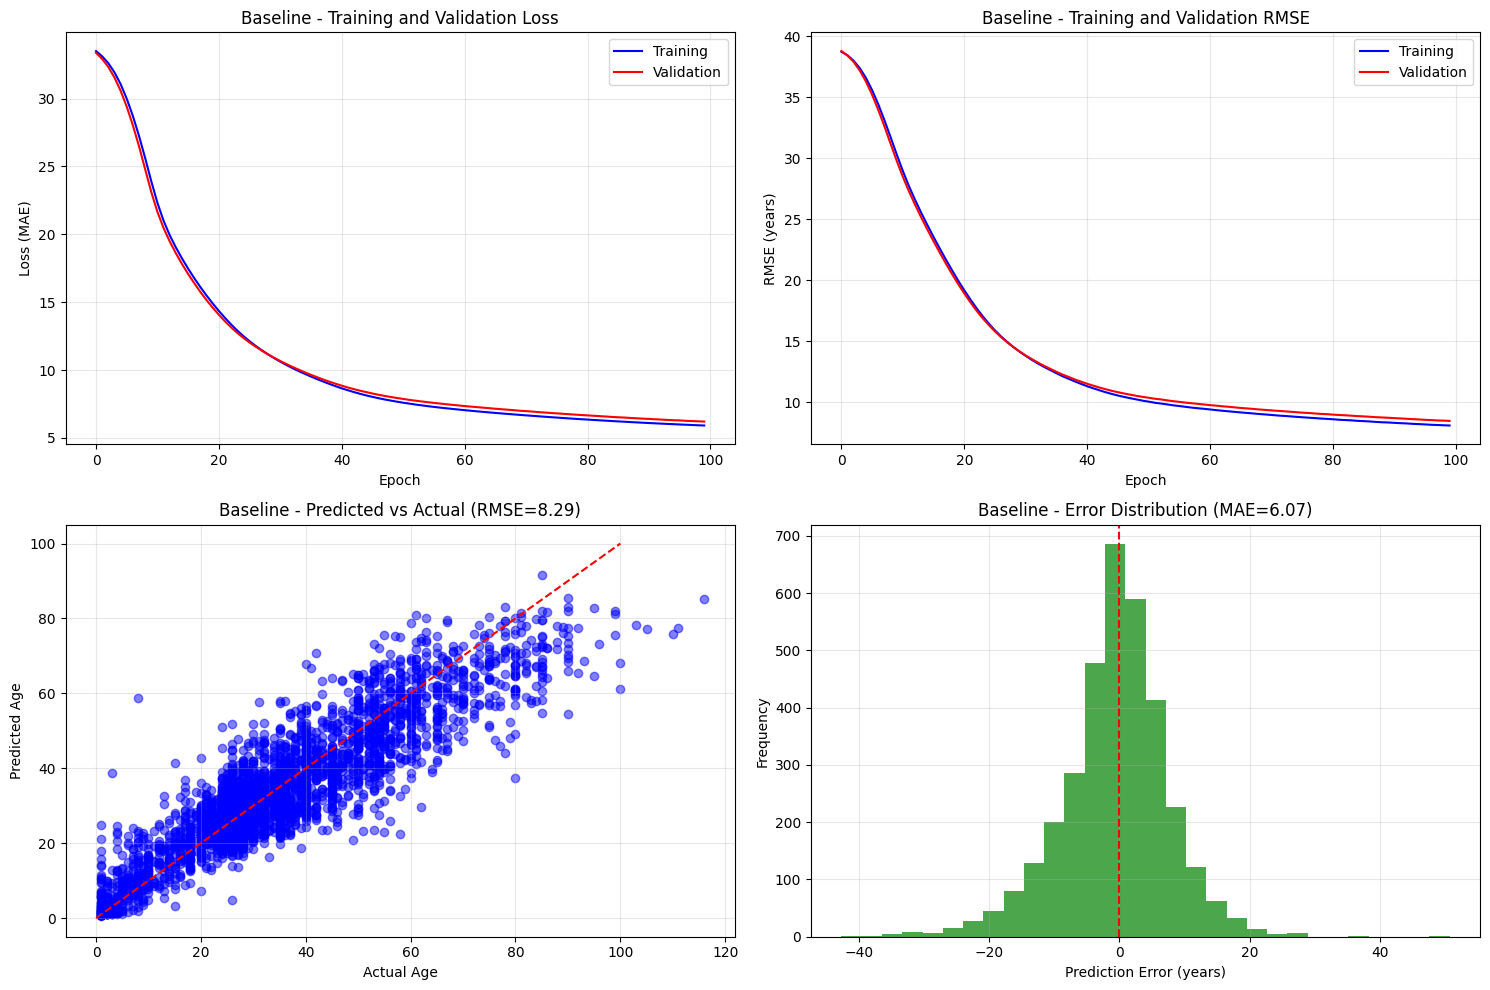


Baseline Results:
Best validation loss: 6.2091
Test RMSE: 8.2929
Test MAE: 6.0676

Training Deep...
Epoch 10/100, Train Loss: 7.3412, Val Loss: 7.3723
Epoch 20/100, Train Loss: 5.4697, Val Loss: 5.7909
Epoch 30/100, Train Loss: 4.8752, Val Loss: 5.3275
Epoch 40/100, Train Loss: 4.5450, Val Loss: 5.1514
Epoch 50/100, Train Loss: 4.3310, Val Loss: 5.0805
Epoch 60/100, Train Loss: 4.1452, Val Loss: 5.0362
Epoch 70/100, Train Loss: 3.9557, Val Loss: 5.0030
Epoch 80/100, Train Loss: 3.7938, Val Loss: 5.0020
Epoch 90/100, Train Loss: 3.6361, Val Loss: 4.9924
Epoch 100/100, Train Loss: 3.4910, Val Loss: 4.9917


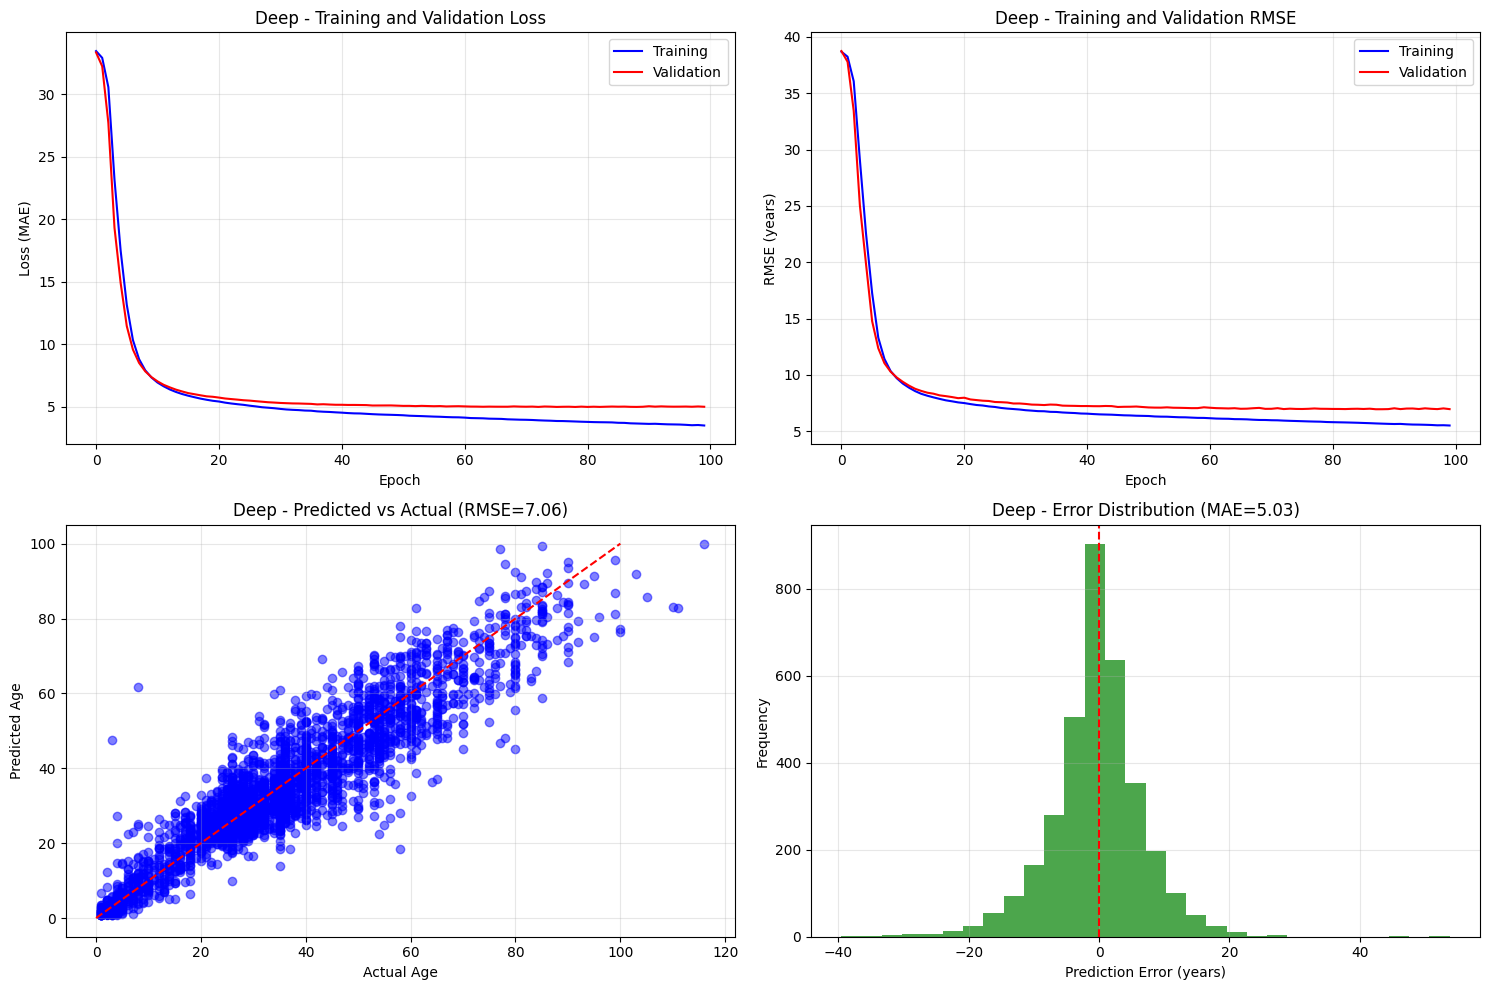


Deep Results:
Best validation loss: 4.9760
Test RMSE: 7.0596
Test MAE: 5.0301

Training Dropout...
Epoch 10/100, Train Loss: 9.6988, Val Loss: 8.7455
Epoch 20/100, Train Loss: 7.0194, Val Loss: 6.1528
Epoch 30/100, Train Loss: 6.5795, Val Loss: 5.7340
Epoch 40/100, Train Loss: 6.3506, Val Loss: 5.5060
Epoch 50/100, Train Loss: 6.2596, Val Loss: 5.4688
Epoch 60/100, Train Loss: 6.1150, Val Loss: 5.3382
Epoch 70/100, Train Loss: 6.0491, Val Loss: 5.2153
Epoch 80/100, Train Loss: 5.9815, Val Loss: 5.1722
Epoch 90/100, Train Loss: 5.9131, Val Loss: 5.1419
Epoch 100/100, Train Loss: 5.8605, Val Loss: 5.0928


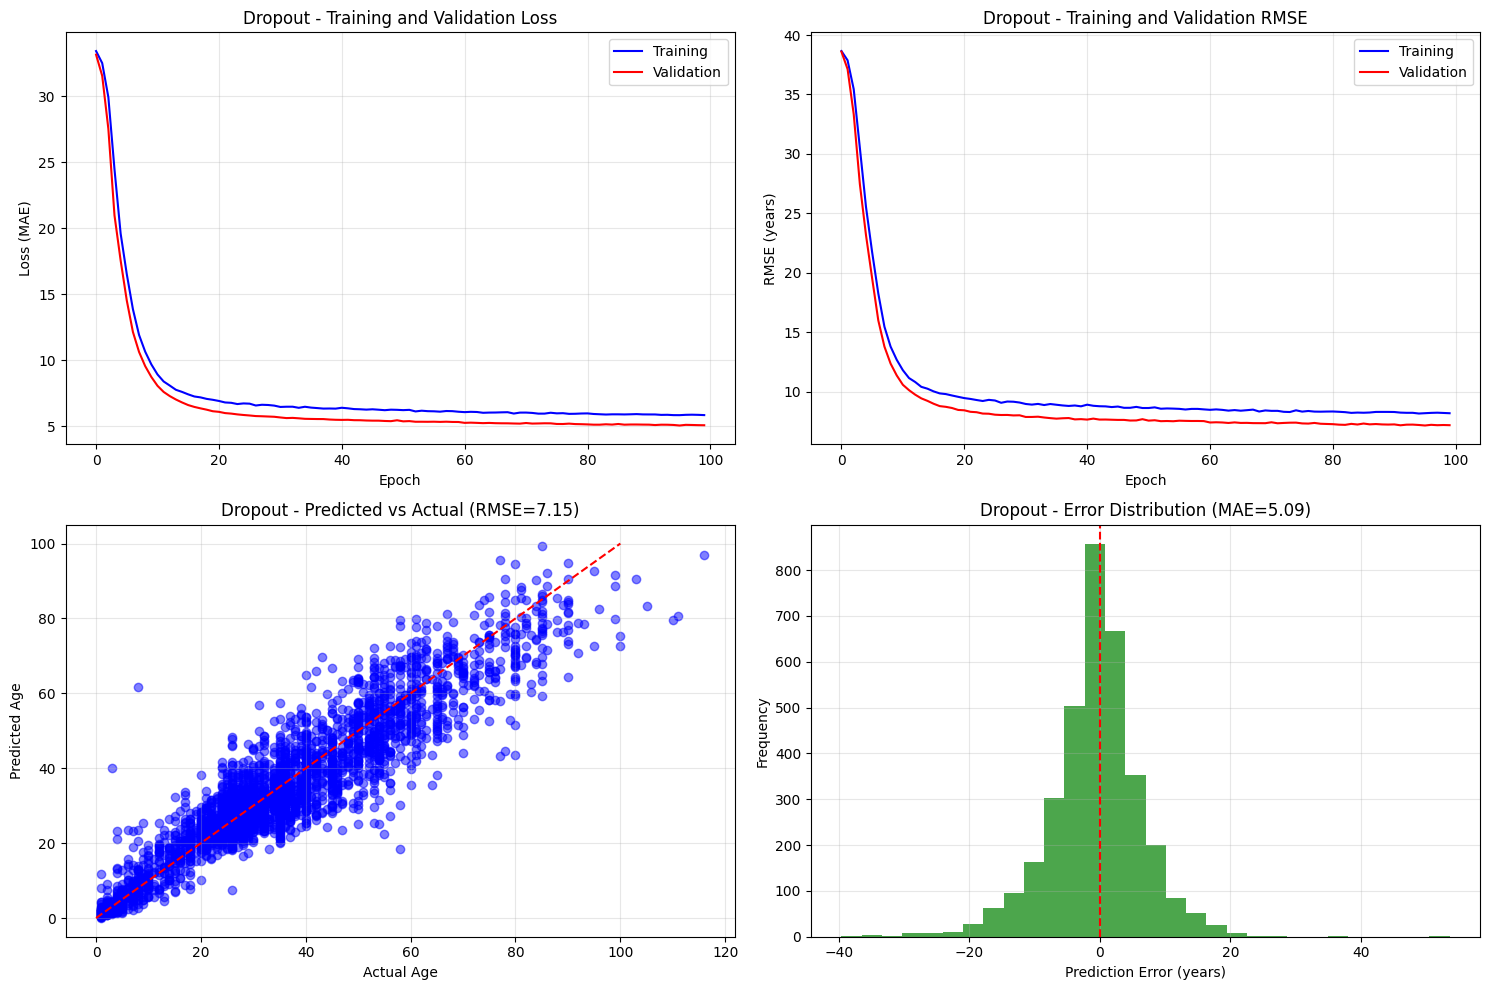


Dropout Results:
Best validation loss: 5.0731
Test RMSE: 7.1519
Test MAE: 5.0946

Training BatchNorm...
Epoch 10/100, Train Loss: 27.5269, Val Loss: 27.2725
Epoch 20/100, Train Loss: 13.7541, Val Loss: 13.4204
Epoch 30/100, Train Loss: 4.2364, Val Loss: 5.1947
Epoch 40/100, Train Loss: 3.4092, Val Loss: 5.0964
Epoch 50/100, Train Loss: 2.9827, Val Loss: 5.1733
Epoch 60/100, Train Loss: 2.6436, Val Loss: 5.2443
Epoch 70/100, Train Loss: 2.4759, Val Loss: 5.3077
Epoch 80/100, Train Loss: 2.2805, Val Loss: 5.3752
Epoch 90/100, Train Loss: 2.0743, Val Loss: 5.3968
Epoch 100/100, Train Loss: 1.9767, Val Loss: 5.3602


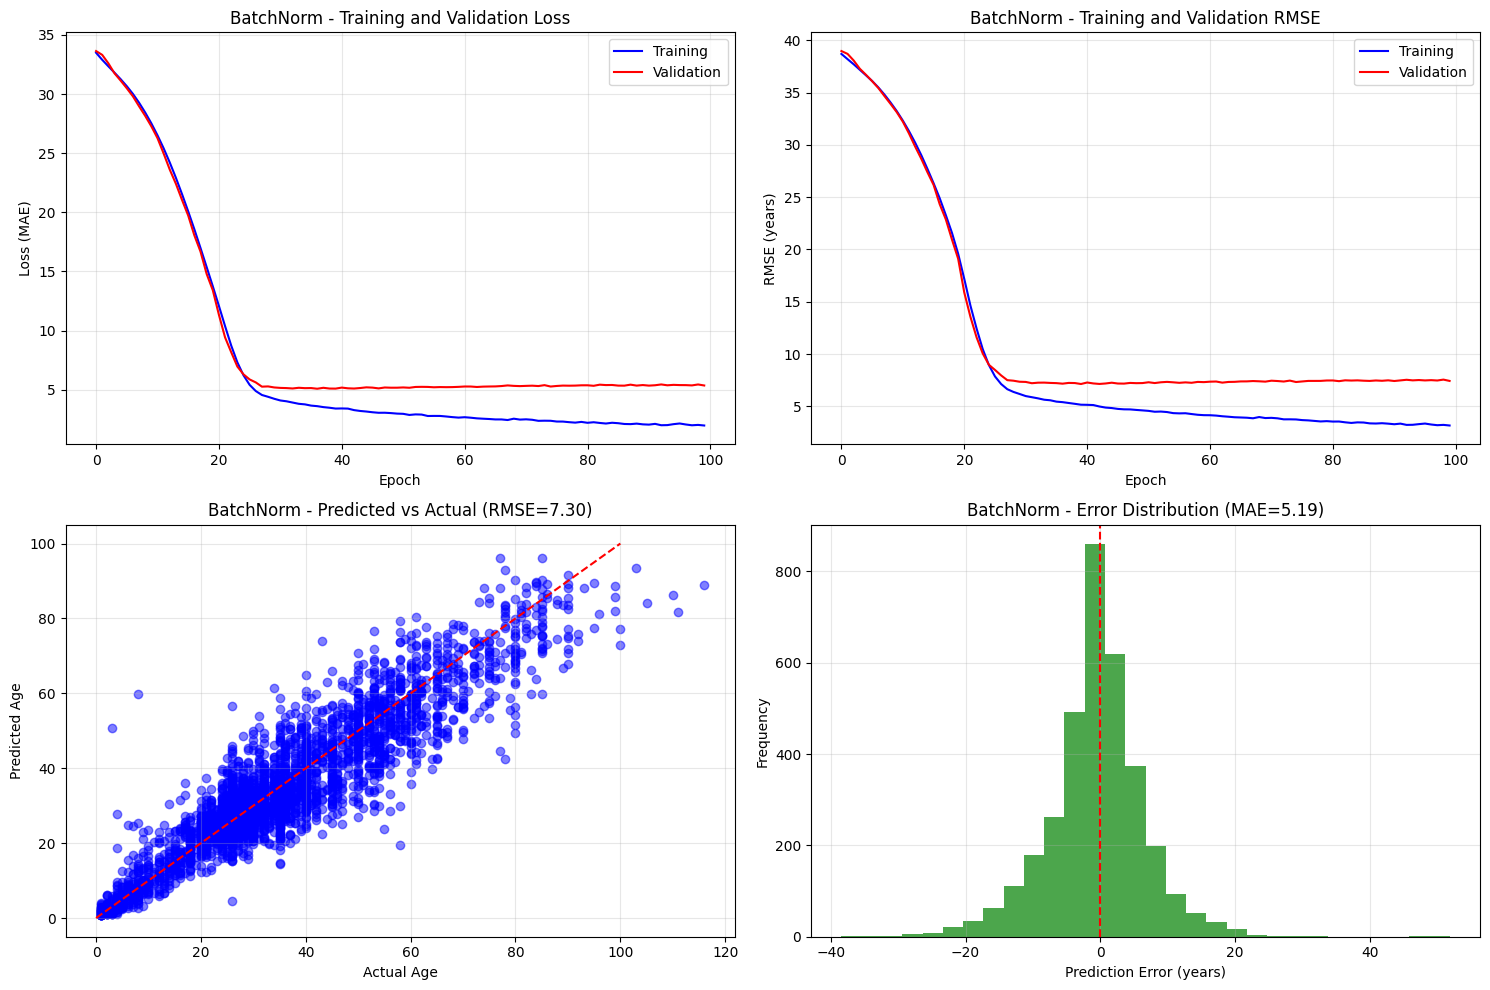


BatchNorm Results:
Best validation loss: 5.0859
Test RMSE: 7.3019
Test MAE: 5.1875

Training Complete...
Epoch 10/100, Train Loss: 27.9358, Val Loss: 27.4439
Epoch 20/100, Train Loss: 13.9110, Val Loss: 13.5252
Epoch 30/100, Train Loss: 5.6941, Val Loss: 5.0869
Epoch 40/100, Train Loss: 5.1763, Val Loss: 4.8276
Epoch 50/100, Train Loss: 4.9219, Val Loss: 4.7804
Epoch 60/100, Train Loss: 4.8653, Val Loss: 4.7835
Epoch 70/100, Train Loss: 4.7202, Val Loss: 4.7799
Epoch 80/100, Train Loss: 4.5851, Val Loss: 4.7607
Epoch 90/100, Train Loss: 4.5038, Val Loss: 4.7574
Epoch 100/100, Train Loss: 4.4195, Val Loss: 4.7503


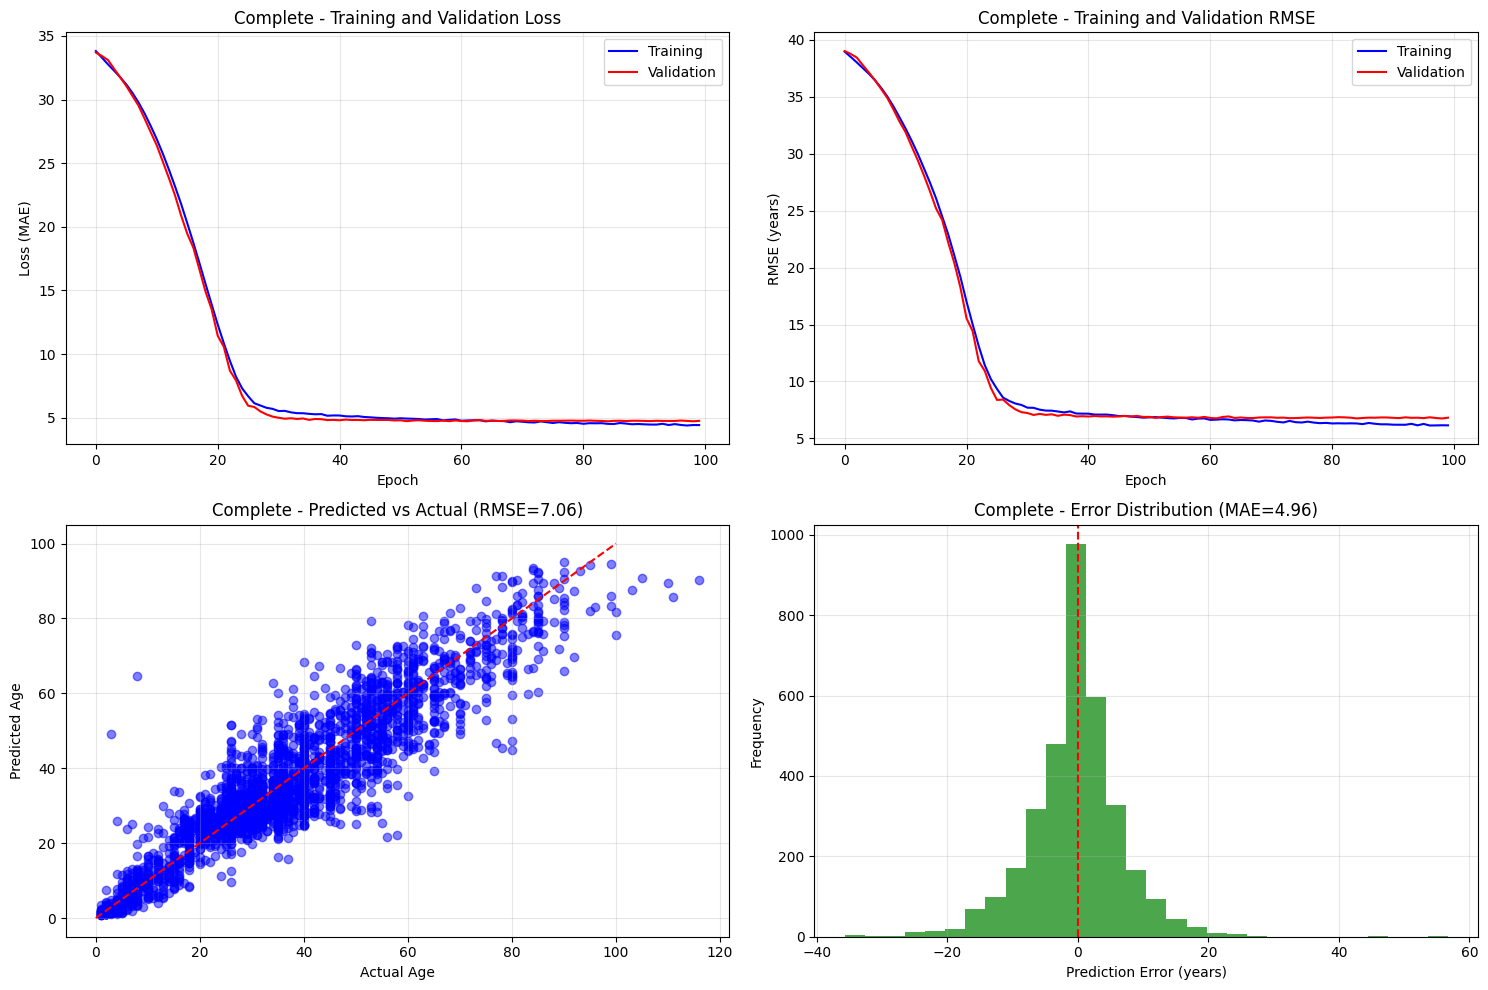


Complete Results:
Best validation loss: 4.7160
Test RMSE: 7.0616
Test MAE: 4.9576

Model Comparison:
------------------------------------------------------------
Model           Test RMSE       Test MAE        Best Val Loss  
------------------------------------------------------------
Baseline        8.2929          6.0676          6.2091         
Deep            7.0596          5.0301          4.9760         
Dropout         7.1519          5.0946          5.0731         
BatchNorm       7.3019          5.1875          5.0859         
Complete        7.0616          4.9576          4.7160         


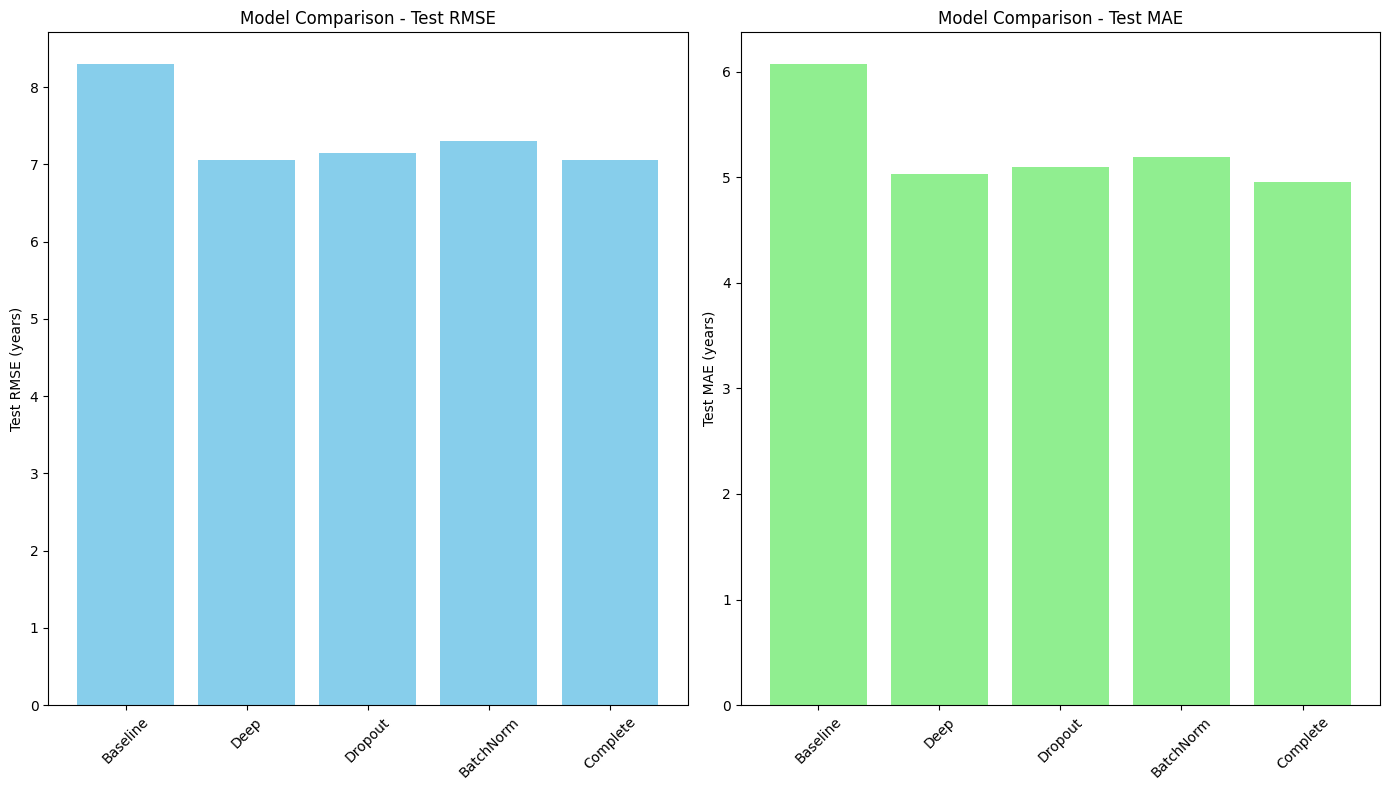

[{'model_name': 'Baseline',
  'test_rmse': 8.292898289203986,
  'test_mae': 6.067582089731166,
  'best_val_loss': 6.209091284300676,
  'history': {'train_loss': [33.500490673906,
    33.110987504124495,
    32.60155100437114,
    31.927144986139048,
    31.062154915919148,
    29.983967497374433,
    28.705039289912076,
    27.234211475753117,
    25.60822036787066,
    23.88854981709457,
    22.30048110242304,
    20.99017088801556,
    19.922914269270525,
    19.025434956897758,
    18.21367304546403,
    17.463145135073535,
    16.757959697733888,
    16.10042772920602,
    15.48137161187121,
    14.899418777187138,
    14.35078360624602,
    13.838063630635421,
    13.353801621834815,
    12.907993976849749,
    12.497036710094445,
    12.121088640195357,
    11.772430876597543,
    11.455623250202086,
    11.155830608536847,
    10.87667073742998,
    10.61703414549552,
    10.369416800683398,
    10.139950313954643,
    9.922260291343157,
    9.717456787325068,
    9.519424686856

In [22]:
from utils.model_architectures import run_experiments

# Run experiments with multiple model architectures (Baseline, Deep, Dropout, BatchNorm, Dropout + BatchNorm)
run_experiments(
    n_features=train_embeddings.shape[1],
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    device=device,
    result_folder=resultFolder,
    epochs=100,
    lr=0.001
)

Overall, the best performing model is the complete one (BatchNorm + Dropout on a deep model), but not by much. The final loss (Mean Absolute Error) is around 5 years which we hope to improve a little by tweaking some parameters.

We try again but with half the learning rate and 10 times more epochs


Training Baseline...
Epoch 10/1000, Train Loss: 30.7619, Val Loss: 30.5354
Epoch 20/1000, Train Loss: 23.6275, Val Loss: 23.2978
Epoch 30/1000, Train Loss: 18.2087, Val Loss: 18.0404
Epoch 40/1000, Train Loss: 15.0013, Val Loss: 14.8514
Epoch 50/1000, Train Loss: 12.6583, Val Loss: 12.6152
Epoch 60/1000, Train Loss: 11.0345, Val Loss: 11.1150
Epoch 70/1000, Train Loss: 9.8610, Val Loss: 10.0221
Epoch 80/1000, Train Loss: 8.9452, Val Loss: 9.1545
Epoch 90/1000, Train Loss: 8.2299, Val Loss: 8.4916
Epoch 100/1000, Train Loss: 7.7233, Val Loss: 8.0128
Epoch 110/1000, Train Loss: 7.3639, Val Loss: 7.6693
Epoch 120/1000, Train Loss: 7.0922, Val Loss: 7.4100
Epoch 130/1000, Train Loss: 6.8740, Val Loss: 7.1964
Epoch 140/1000, Train Loss: 6.6869, Val Loss: 7.0067
Epoch 150/1000, Train Loss: 6.5204, Val Loss: 6.8391
Epoch 160/1000, Train Loss: 6.3697, Val Loss: 6.6811
Epoch 170/1000, Train Loss: 6.2332, Val Loss: 6.5398
Epoch 180/1000, Train Loss: 6.1096, Val Loss: 6.4110
Epoch 190/1000, Trai

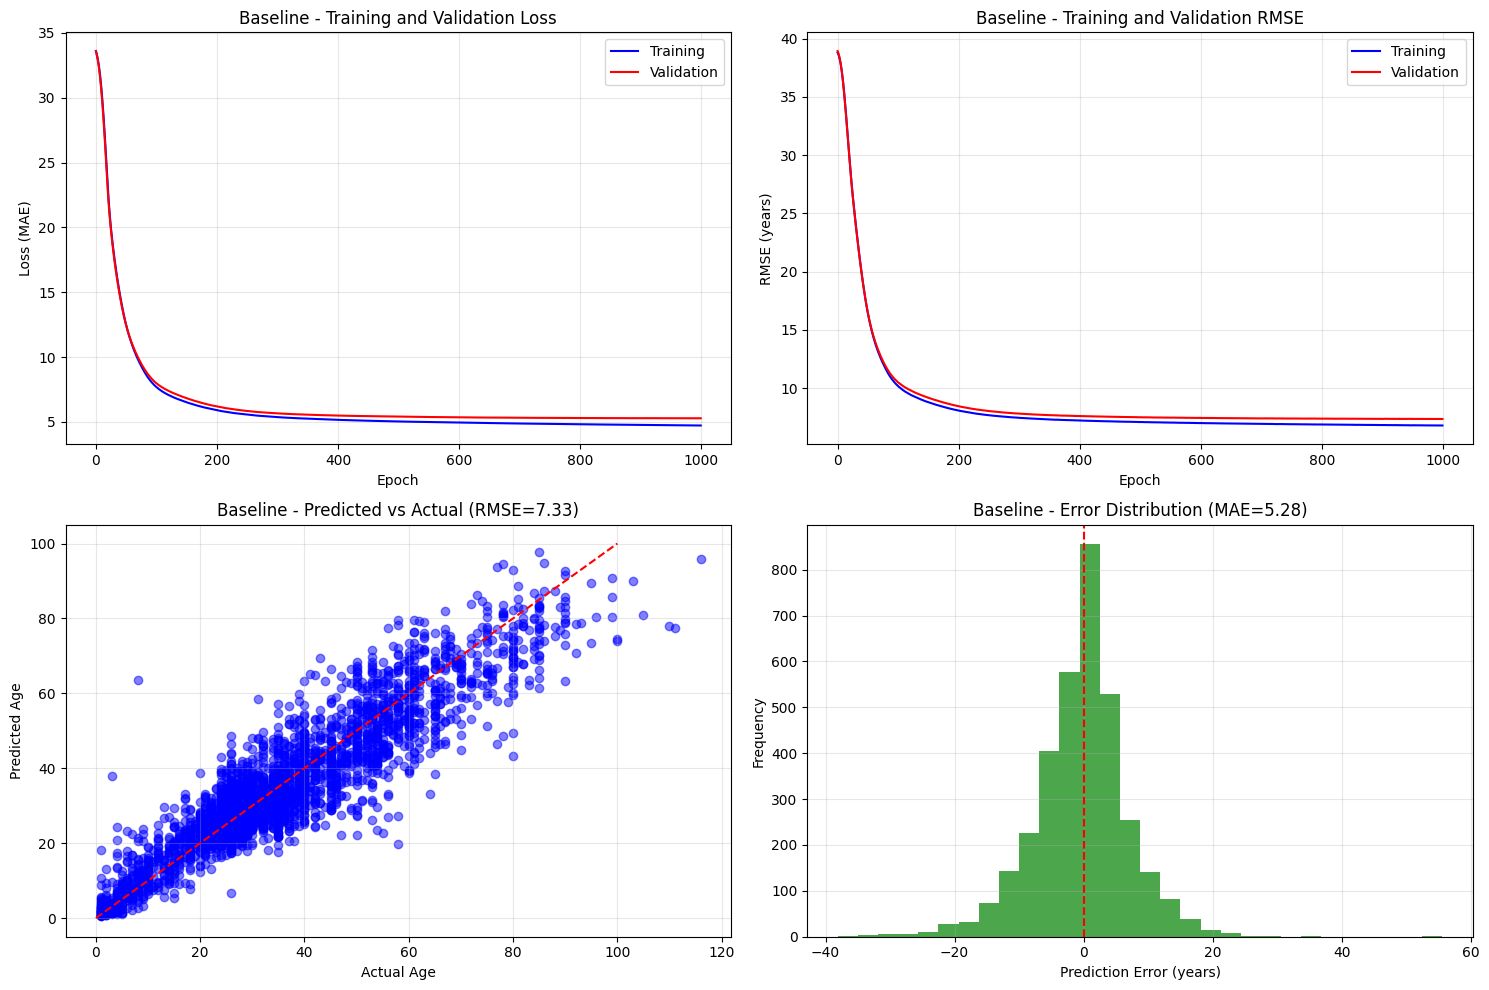


Baseline Results:
Best validation loss: 5.2733
Test RMSE: 7.3330
Test MAE: 5.2798

Training Deep...
Epoch 10/1000, Train Loss: 11.5397, Val Loss: 10.7698
Epoch 20/1000, Train Loss: 6.3236, Val Loss: 6.5595
Epoch 30/1000, Train Loss: 5.4650, Val Loss: 5.7898
Epoch 40/1000, Train Loss: 5.0018, Val Loss: 5.4098
Epoch 50/1000, Train Loss: 4.7593, Val Loss: 5.2346
Epoch 60/1000, Train Loss: 4.5832, Val Loss: 5.1457
Epoch 70/1000, Train Loss: 4.4526, Val Loss: 5.0803
Epoch 80/1000, Train Loss: 4.3312, Val Loss: 5.0564
Epoch 90/1000, Train Loss: 4.2219, Val Loss: 5.0021
Epoch 100/1000, Train Loss: 4.1137, Val Loss: 4.9692
Epoch 110/1000, Train Loss: 4.0193, Val Loss: 4.9579
Epoch 120/1000, Train Loss: 3.9095, Val Loss: 4.9596
Epoch 130/1000, Train Loss: 3.8200, Val Loss: 4.9365
Epoch 140/1000, Train Loss: 3.7207, Val Loss: 4.9354
Epoch 150/1000, Train Loss: 3.6320, Val Loss: 4.9479
Epoch 160/1000, Train Loss: 3.5330, Val Loss: 4.9461
Epoch 170/1000, Train Loss: 3.4399, Val Loss: 4.9640
Epoch

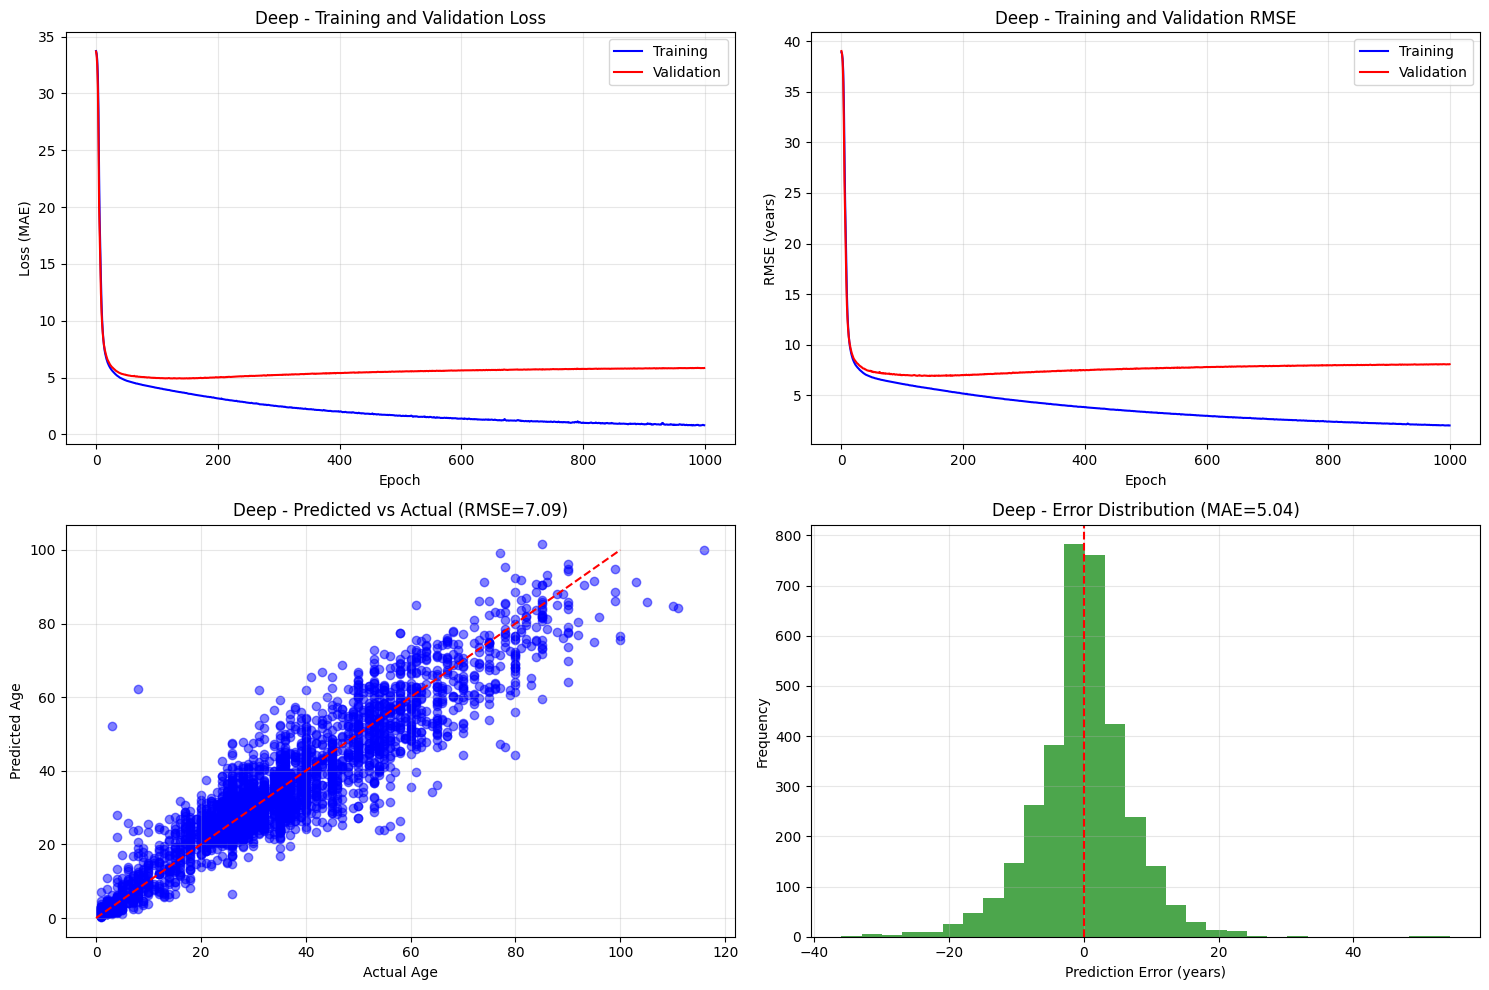


Deep Results:
Best validation loss: 4.9251
Test RMSE: 7.0935
Test MAE: 5.0449

Training Dropout...
Epoch 10/1000, Train Loss: 14.7828, Val Loss: 13.4700
Epoch 20/1000, Train Loss: 8.0170, Val Loss: 7.5237
Epoch 30/1000, Train Loss: 6.9988, Val Loss: 6.3635
Epoch 40/1000, Train Loss: 6.6156, Val Loss: 5.8906
Epoch 50/1000, Train Loss: 6.4084, Val Loss: 5.6803
Epoch 60/1000, Train Loss: 6.2732, Val Loss: 5.5621
Epoch 70/1000, Train Loss: 6.1574, Val Loss: 5.4869
Epoch 80/1000, Train Loss: 6.0946, Val Loss: 5.4046
Epoch 90/1000, Train Loss: 6.0398, Val Loss: 5.3555
Epoch 100/1000, Train Loss: 5.9741, Val Loss: 5.3227
Epoch 110/1000, Train Loss: 5.9280, Val Loss: 5.2757
Epoch 120/1000, Train Loss: 5.9012, Val Loss: 5.2528
Epoch 130/1000, Train Loss: 5.8662, Val Loss: 5.2233
Epoch 140/1000, Train Loss: 5.7989, Val Loss: 5.1945
Epoch 150/1000, Train Loss: 5.8140, Val Loss: 5.1645
Epoch 160/1000, Train Loss: 5.7709, Val Loss: 5.1471
Epoch 170/1000, Train Loss: 5.7311, Val Loss: 5.1534
Epoch 

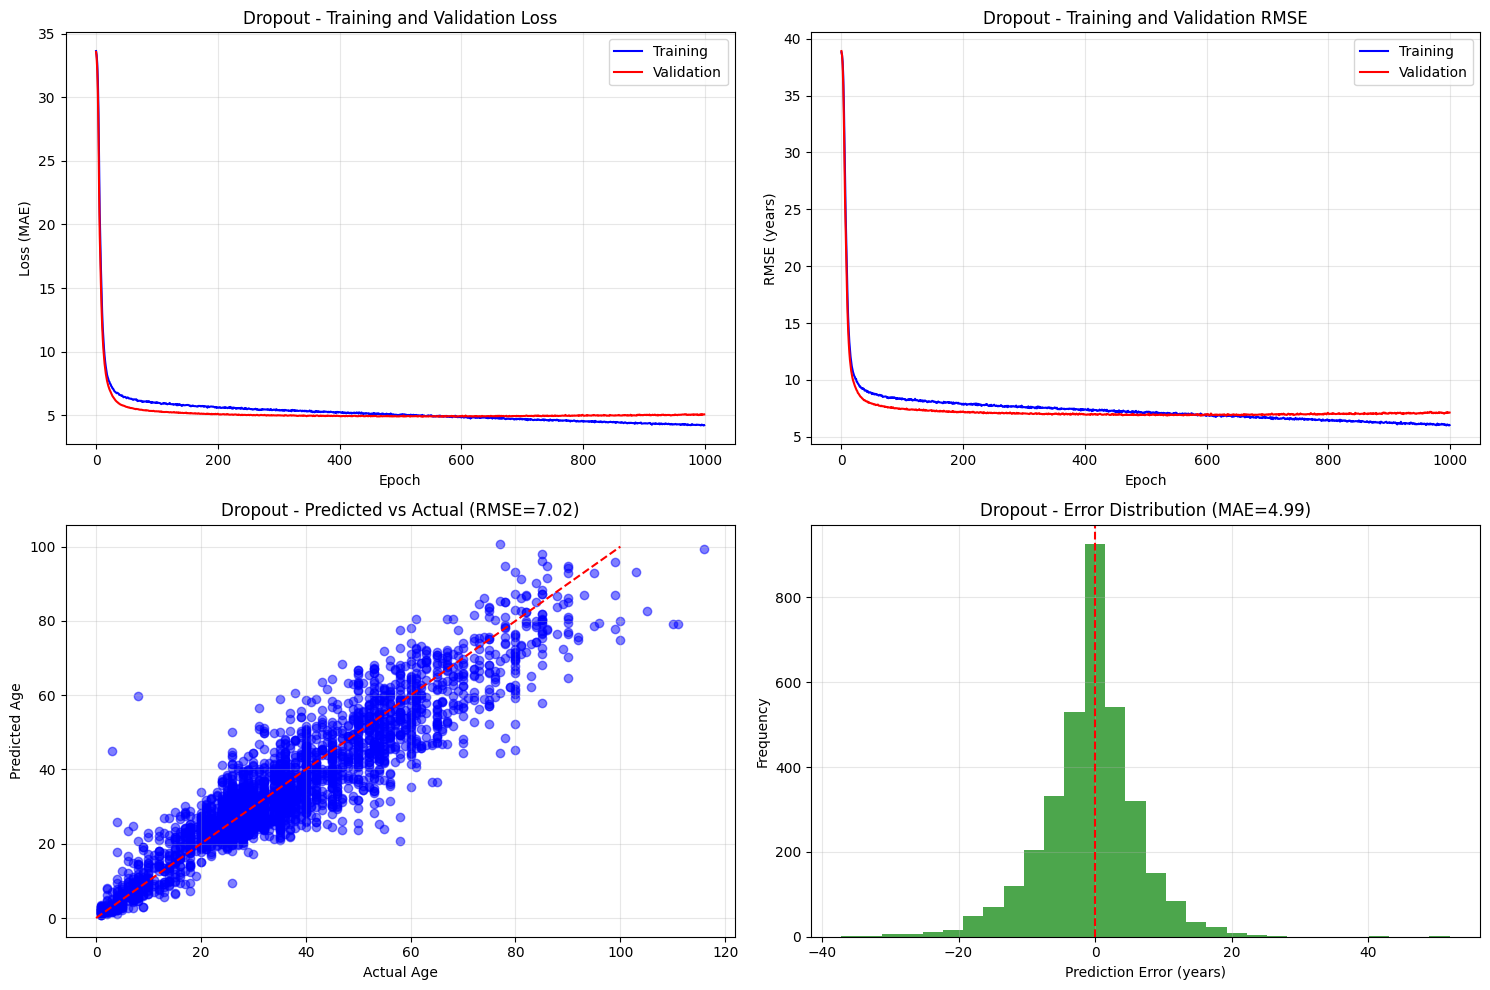


Dropout Results:
Best validation loss: 4.8902
Test RMSE: 7.0199
Test MAE: 4.9880

Training BatchNorm...
Epoch 10/1000, Train Loss: 30.5587, Val Loss: 30.5727
Epoch 20/1000, Train Loss: 26.1748, Val Loss: 26.0638
Epoch 30/1000, Train Loss: 19.7001, Val Loss: 19.5986
Epoch 40/1000, Train Loss: 11.7353, Val Loss: 11.3142
Epoch 50/1000, Train Loss: 5.2397, Val Loss: 5.9111
Epoch 60/1000, Train Loss: 3.7166, Val Loss: 5.0486
Epoch 70/1000, Train Loss: 3.2178, Val Loss: 5.1889
Epoch 80/1000, Train Loss: 2.8075, Val Loss: 5.1924
Epoch 90/1000, Train Loss: 2.5605, Val Loss: 5.2811
Epoch 100/1000, Train Loss: 2.3286, Val Loss: 5.2718
Epoch 110/1000, Train Loss: 2.1975, Val Loss: 5.3041
Epoch 120/1000, Train Loss: 2.0502, Val Loss: 5.3201
Epoch 130/1000, Train Loss: 1.9667, Val Loss: 5.3876
Epoch 140/1000, Train Loss: 1.7998, Val Loss: 5.3506
Epoch 150/1000, Train Loss: 1.7822, Val Loss: 5.3742
Epoch 160/1000, Train Loss: 1.7016, Val Loss: 5.4519
Epoch 170/1000, Train Loss: 1.7245, Val Loss: 5.

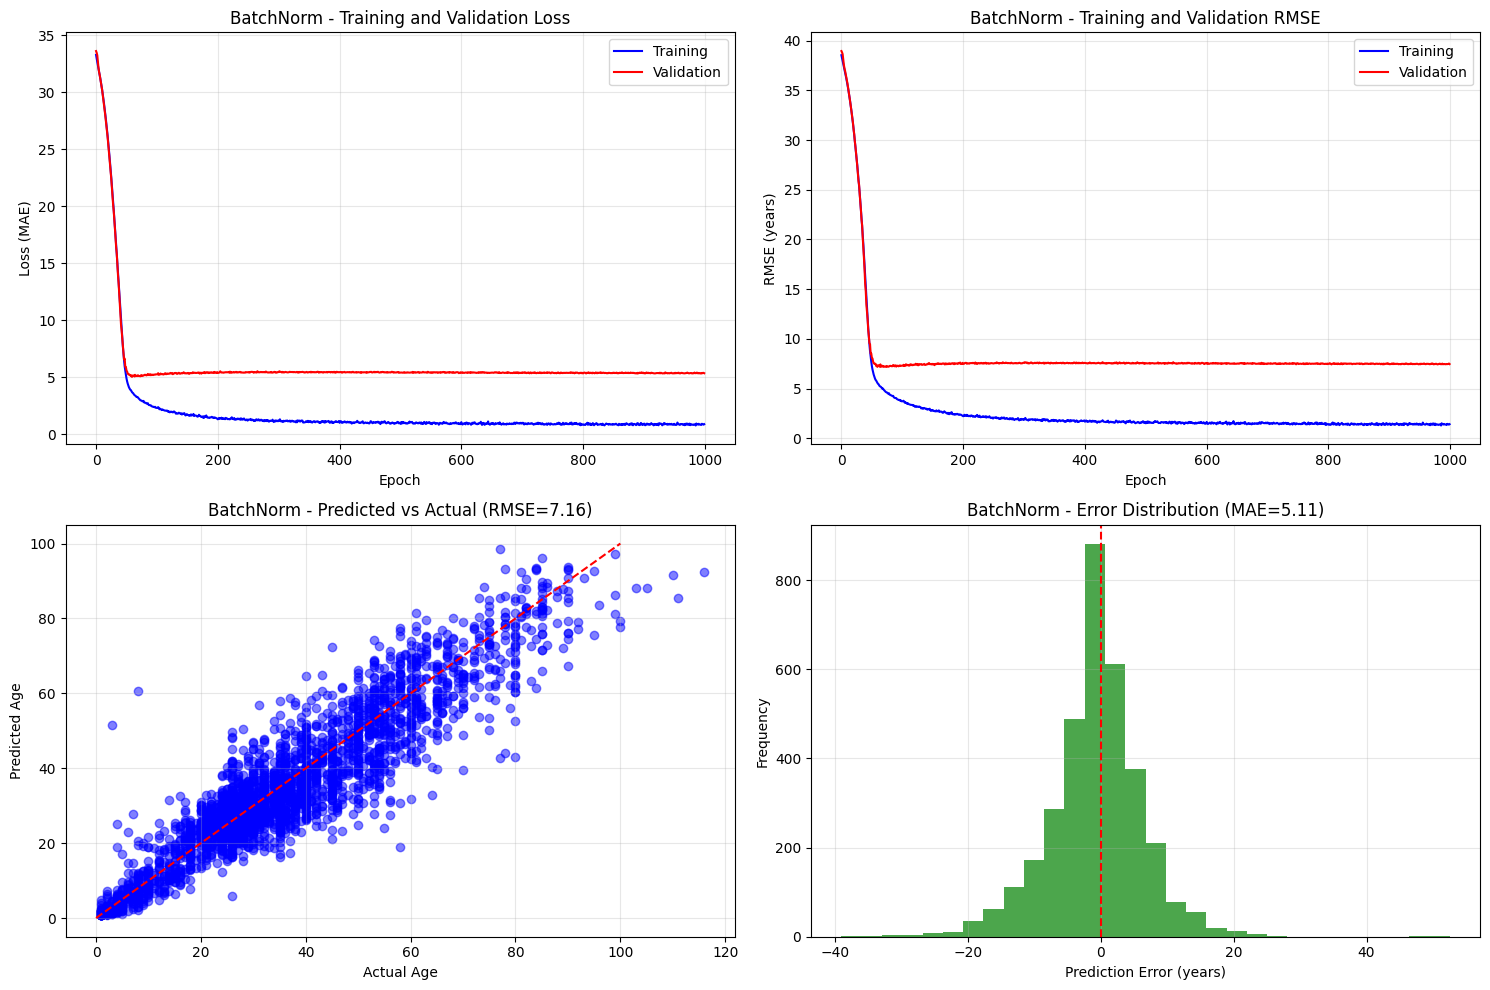


BatchNorm Results:
Best validation loss: 5.0486
Test RMSE: 7.1627
Test MAE: 5.1090

Training Complete...
Epoch 10/1000, Train Loss: 30.9375, Val Loss: 31.0128
Epoch 20/1000, Train Loss: 26.3360, Val Loss: 25.9767
Epoch 30/1000, Train Loss: 19.8615, Val Loss: 19.2061
Epoch 40/1000, Train Loss: 12.3927, Val Loss: 11.8293
Epoch 50/1000, Train Loss: 7.0845, Val Loss: 6.9761
Epoch 60/1000, Train Loss: 5.6461, Val Loss: 5.1600
Epoch 70/1000, Train Loss: 5.2362, Val Loss: 4.9421
Epoch 80/1000, Train Loss: 5.1145, Val Loss: 4.8208
Epoch 90/1000, Train Loss: 4.9192, Val Loss: 4.8534
Epoch 100/1000, Train Loss: 4.8167, Val Loss: 4.8600
Epoch 110/1000, Train Loss: 4.6615, Val Loss: 4.8485
Epoch 120/1000, Train Loss: 4.5803, Val Loss: 4.7921
Epoch 130/1000, Train Loss: 4.4896, Val Loss: 4.7886
Epoch 140/1000, Train Loss: 4.4195, Val Loss: 4.7633
Epoch 150/1000, Train Loss: 4.2929, Val Loss: 4.7727
Epoch 160/1000, Train Loss: 4.2593, Val Loss: 4.8411
Epoch 170/1000, Train Loss: 4.1773, Val Loss: 4

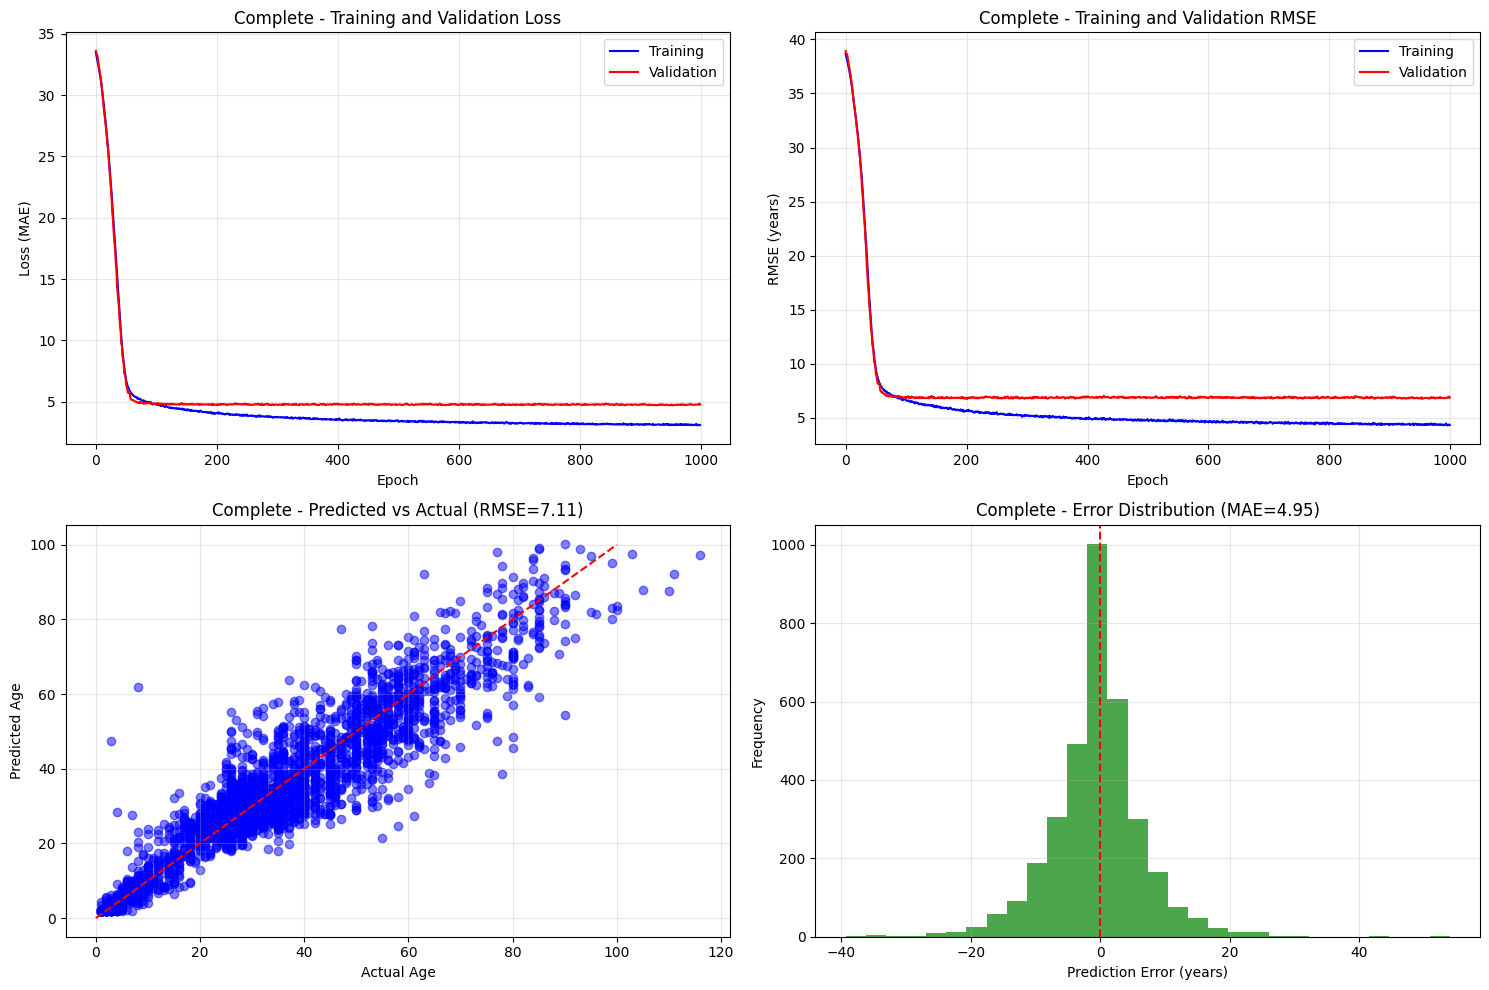


Complete Results:
Best validation loss: 4.6956
Test RMSE: 7.1078
Test MAE: 4.9524

Model Comparison:
------------------------------------------------------------
Model           Test RMSE       Test MAE        Best Val Loss  
------------------------------------------------------------
Baseline        7.3330          5.2798          5.2733         
Deep            7.0935          5.0449          4.9251         
Dropout         7.0199          4.9880          4.8902         
BatchNorm       7.1627          5.1090          5.0486         
Complete        7.1078          4.9524          4.6956         


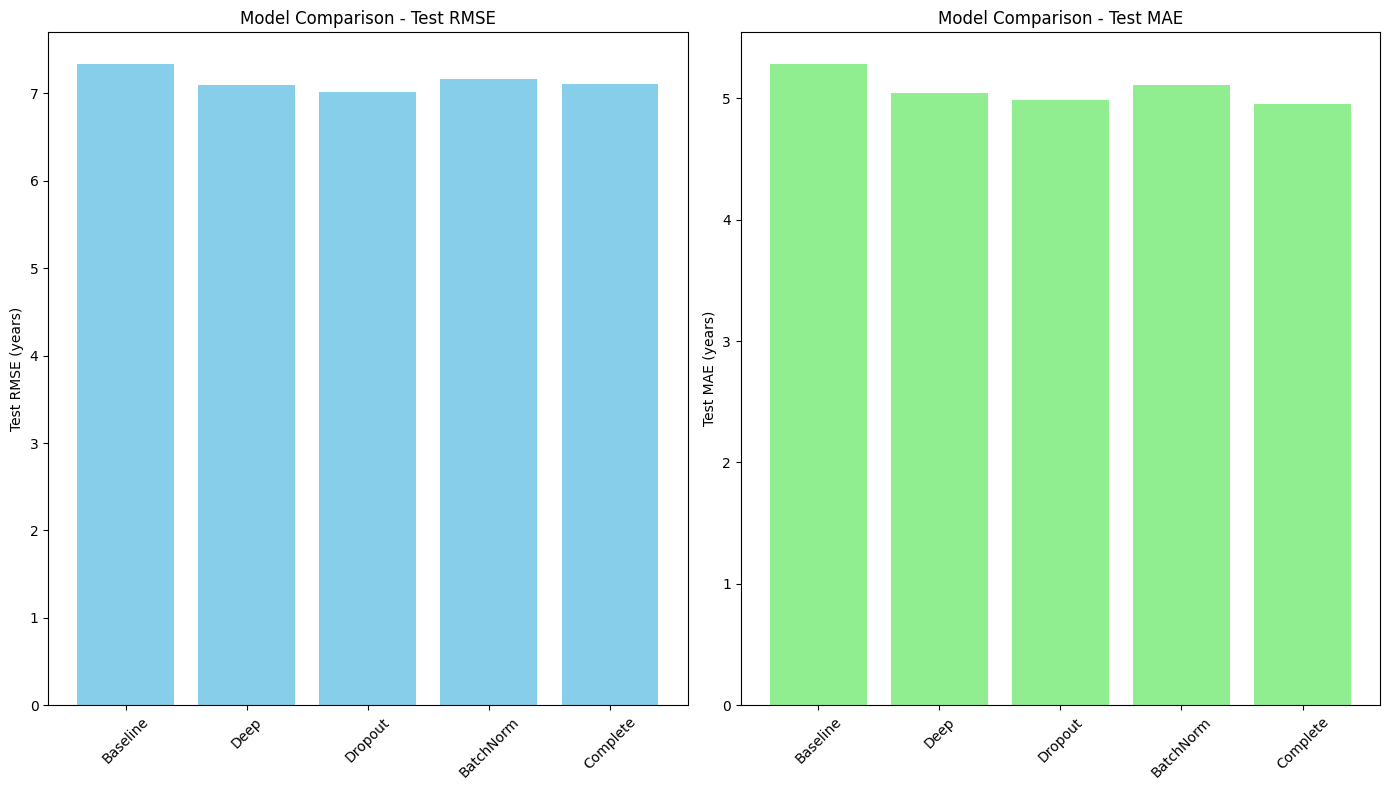

[{'model_name': 'Baseline',
  'test_rmse': 7.332960511577927,
  'test_mae': 5.279838684114606,
  'best_val_loss': 5.273297476484579,
  'history': {'train_loss': [33.59725902042957,
    33.444052686922724,
    33.24142405090256,
    33.01532509340654,
    32.75604475573477,
    32.45411372333877,
    32.10414772043235,
    31.7042779762625,
    31.256419491761918,
    30.761885606977145,
    30.217331609279775,
    29.627605625292883,
    28.996460232461487,
    28.319250176482,
    27.608708011588067,
    26.859896875781835,
    26.078338031802204,
    25.271760466697067,
    24.44612805068508,
    23.627532184019607,
    22.846955802579625,
    22.131474754289595,
    21.487187369095853,
    20.90454056038092,
    20.375560682238056,
    19.882419326110337,
    19.427494297213695,
    18.999891438602297,
    18.594715679589587,
    18.208681786570335,
    17.838189781442832,
    17.479794905249523,
    17.13441875382367,
    16.800561401466442,
    16.47354344197861,
    16.1612617195

In [23]:
run_experiments(
    n_features=train_embeddings.shape[1],
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    device=device,
    result_folder=resultFolder,
    epochs=1000,
    lr=0.0005
)

With regularization, the model learns very fast. We could try to decrease the learning rate more, or use a scheduler.

Training CompleteModelWithLowLR...
Epoch 10/500, Train Loss: 33.1228, Val Loss: 33.3089
Epoch 20/500, Train Loss: 32.5540, Val Loss: 32.7732
Epoch 30/500, Train Loss: 31.9895, Val Loss: 32.1559
Epoch 40/500, Train Loss: 31.3855, Val Loss: 31.5050
Epoch 50/500, Train Loss: 30.7430, Val Loss: 30.8534
Epoch 60/500, Train Loss: 30.0334, Val Loss: 30.1369
Epoch 70/500, Train Loss: 29.2866, Val Loss: 29.3865
Epoch 80/500, Train Loss: 28.4368, Val Loss: 28.5567
Epoch 90/500, Train Loss: 27.5053, Val Loss: 27.6333
Epoch 100/500, Train Loss: 26.4734, Val Loss: 26.6086
Epoch 110/500, Train Loss: 25.3612, Val Loss: 25.5428
Epoch 120/500, Train Loss: 24.2041, Val Loss: 24.3607
Epoch 130/500, Train Loss: 23.0279, Val Loss: 23.1704
Epoch 140/500, Train Loss: 21.7506, Val Loss: 22.0420
Epoch 150/500, Train Loss: 20.4830, Val Loss: 20.7546
Epoch 160/500, Train Loss: 19.1830, Val Loss: 19.4096
Epoch 170/500, Train Loss: 17.8947, Val Loss: 18.1611
Epoch 180/500, Train Loss: 16.5299, Val Loss: 16.8634
Ep

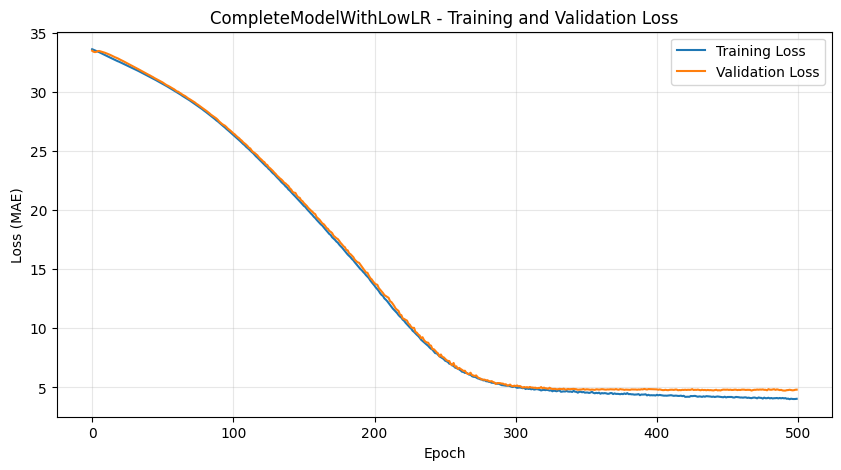

In [24]:
from utils.model_architectures import train_model, CompleteModel

model = train_model(
    model_class=CompleteModel,
    model_name='CompleteModelWithLowLR',
    n_features=train_embeddings.shape[1],
    train_loader=train_loader,
    valid_loader=valid_loader,
    device=device,
    result_folder=resultFolder,
    epochs=500,
    lr=0.0001
)

Test Results - RMSE: 6.9844, MAE: 4.8918


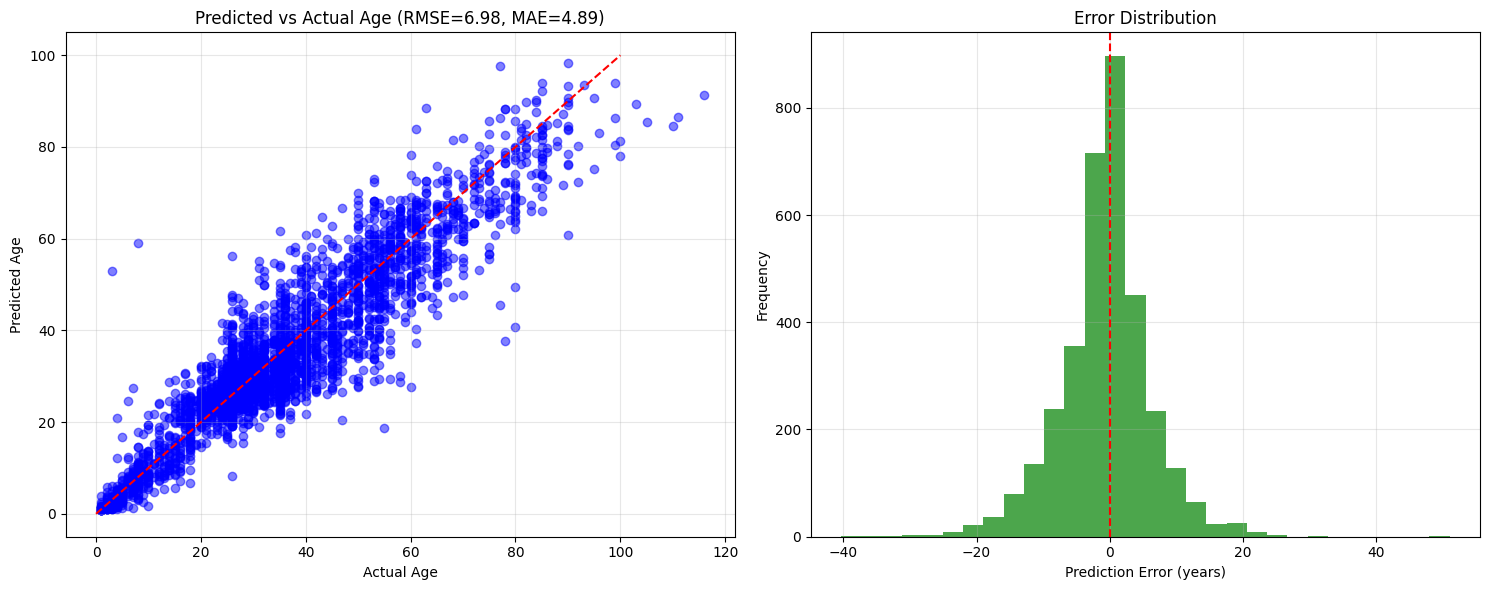

Saved test results visualization to ../models/td3/result/Part2/testResults.png


In [25]:
# Predict on test set
allYtest = []
allYtrue = []

with torch.no_grad():
    for embeddings, ages, _ in test_loader:
        embeddings, ages = embeddings.to(device), ages.to(device)
        outputs = model(embeddings)
        allYtest.extend(outputs.squeeze().cpu().numpy())
        allYtrue.extend(ages.cpu().numpy())

# Convert to numpy arrays
allYtest = np.array(allYtest)
allYtrue = np.array(allYtrue)

# Compute the prediction error and RMSE
error = allYtest - allYtrue
test_rmse = np.sqrt(np.mean(error**2))
test_mae = np.mean(np.abs(error))
print(f'Test Results - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}')

# Visualize predicted vs actual age and error distribution
plt.figure(figsize=(15, 6))

# Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(allYtrue, allYtest, alpha=0.5, color='blue')
plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title(f'Predicted vs Actual Age (RMSE={test_rmse:.2f}, MAE={test_mae:.2f})')
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 2, 2)
plt.hist(error, bins=30, alpha=0.7, color='green')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error (years)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
results_path = os.path.join(resultFolder, "testResults.png")
plt.savefig(results_path)
plt.show()
print(f"Saved test results visualization to {results_path}")

reg_actual_ages, reg_predicted_ages = allYtrue, allYtest

### Discussion of Results
The architectural experiments reveal important patterns in model performance for age prediction:

- Architecture Impact: While the CompleteModel (with both BatchNorm and Dropout) achieves the best performance, the margin is smaller than expected. This suggests that:

    - The extracted embeddings already capture highly relevant features
    - The main bottleneck may be in the inherent limitations of age prediction rather than model capacity


- Regularization Benefits: Models with regularization (BatchNorm and Dropout) show:

    - More stable validation curves
    - Better generalization to test data
    - Reduced overfitting compared to simpler models


- Depth vs. Complexity: The DeepModel shows modest improvements over the Baseline, but the most significant gains come from adding regularization techniques rather than just increasing depth.

- Learning Rate Sensitivity: When we reduced the learning rate and extended training time:

    - Models with regularization continued to gradually improve.
    - Performance plateaued at MAE ≈ 5 years, suggesting we may be approaching the limit of what's possible with this embedding representation


- Efficiency Considerations: Given the minimal difference between the CompleteModel and simpler regularized models, a BatchNormModel might offer the best trade-off between accuracy and computational efficiency for deployment scenarios.

# Going Further

We define the new dataset and models in `utils/model_architectures_going_further.py`

Number of age bins: 24
Age bin width: 5 years
Embeddings shape: torch.Size([64, 1792])
Age bins shape: torch.Size([64])
First few age bins: tensor([ 5,  6,  4,  9, 13,  7, 10,  4,  5, 15])
Training AgeBin_Regularized...
Saved new best model with validation loss: 1.6841
Saved new best model with validation loss: 1.5978
Saved new best model with validation loss: 1.5714
Saved new best model with validation loss: 1.5610
Saved new best model with validation loss: 1.5358
Saved new best model with validation loss: 1.5312
Saved new best model with validation loss: 1.5118
Epoch 10/100, Train Loss: 1.5140, Train Acc: 0.4125, Val Loss: 1.5126, Val Acc: 0.4063
Saved new best model with validation loss: 1.5018
Epoch 20/100, Train Loss: 1.4248, Train Acc: 0.4379, Val Loss: 1.5188, Val Acc: 0.4148
Epoch 30/100, Train Loss: 1.3655, Train Acc: 0.4579, Val Loss: 1.5219, Val Acc: 0.4075
Epoch 40/100, Train Loss: 1.3131, Train Acc: 0.4813, Val Loss: 1.5447, Val Acc: 0.4136
Epoch 50/100, Train Loss: 1.2614

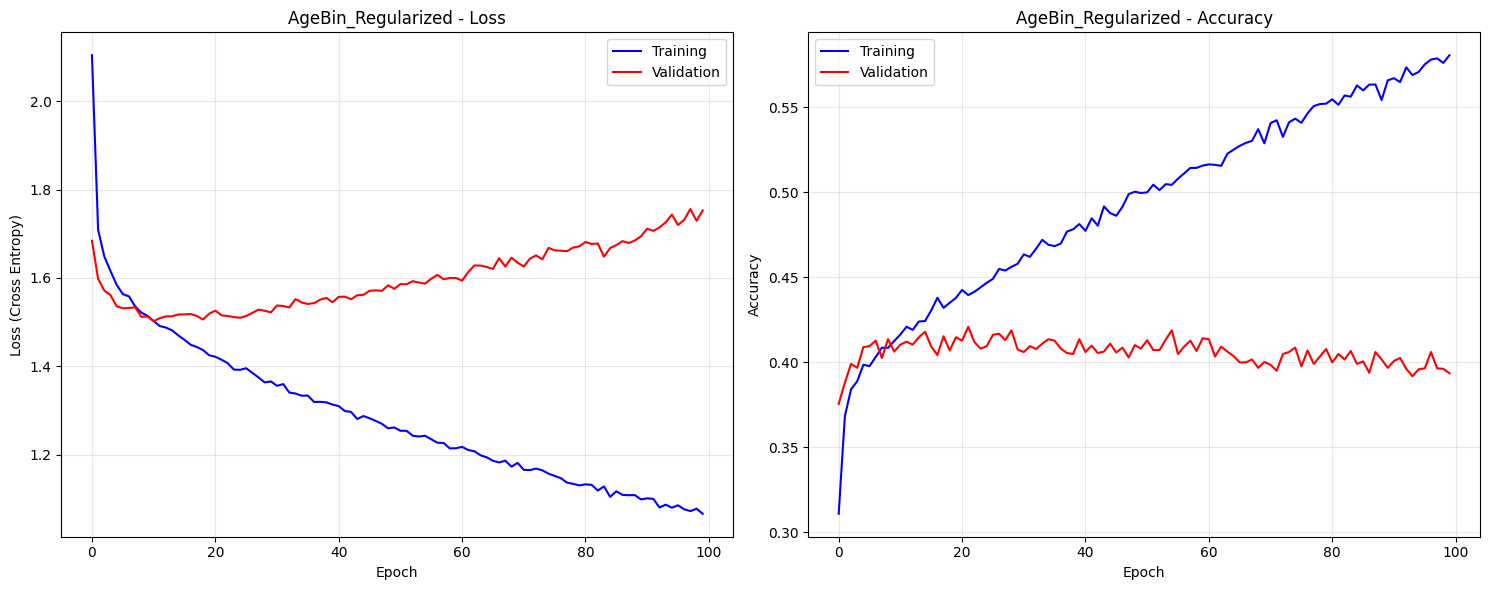

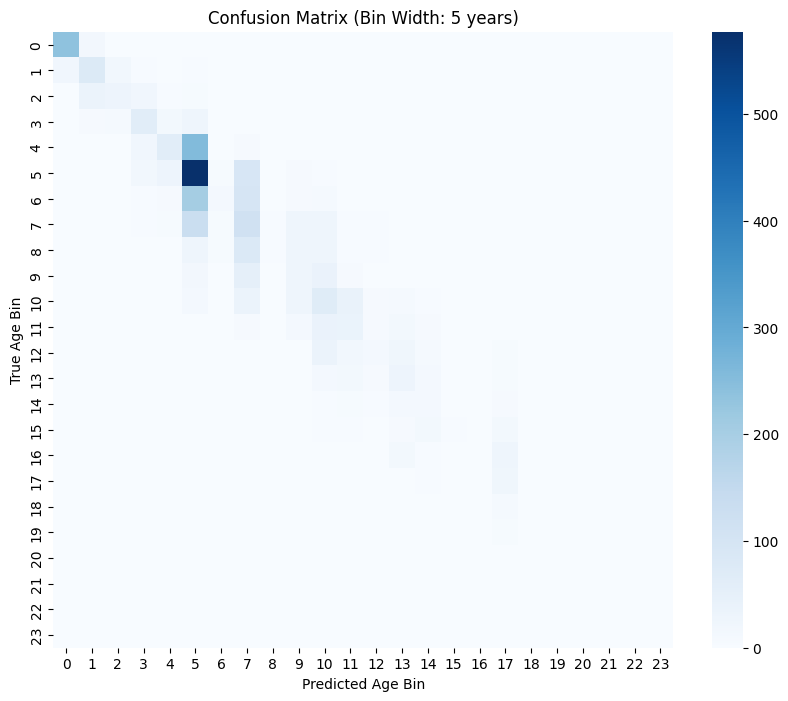

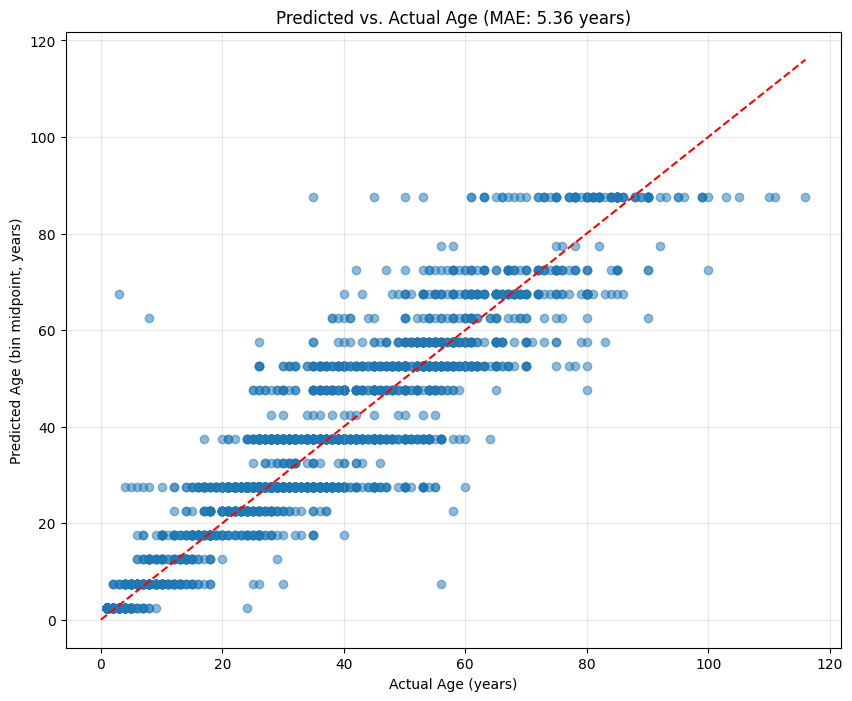


Evaluation Metrics for AgeBin_Regularized (Bin Width: 5 years):
Classification Accuracy: 0.4067
Mean Absolute Error (years): 5.36
Mean Bins Off: 1.02
Median Bins Off: 1.00


In [26]:
from torch.utils.data import DataLoader
from utils.model_architectures_going_further import (
    AgeBinDataset,
    RegularizedClassifier,
    train_classifier,
    evaluate_classifier,
    compare_bin_widths
)

# Configuration parameters
bin_width = 5  # Age bins of 5 years (0-4, 5-9, 10-14, etc.)
batch_size = 64
learning_rate = 0.001
num_epochs = 100
result_folder = os.path.join("../models/td3/result", "Part2_AgeBins")

# Create results directory if it doesn't exist
if not os.path.isdir(result_folder):
    os.makedirs(result_folder)

# Create age bin datasets
train_dataset = AgeBinDataset(train_embeddings, train_ages, train_filenames, bin_width)
valid_dataset = AgeBinDataset(valid_embeddings, valid_ages, valid_filenames, bin_width)
test_dataset = AgeBinDataset(test_embeddings, test_ages, test_filenames, bin_width)

print(f"Number of age bins: {train_dataset.num_bins}")
print(f"Age bin width: {bin_width} years")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get a batch to examine
for embeddings, age_bins, filenames in train_loader:
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Age bins shape: {age_bins.shape}")
    print(f"First few age bins: {age_bins[:10]}")
    break

# Create and train the RegularizedClassifier model
num_features = train_embeddings.shape[1]
num_bins = train_dataset.num_bins
model = RegularizedClassifier(num_features, num_bins)

# Train the model
trained_model = train_classifier(
    model=model,
    model_name="AgeBin_Regularized",
    train_loader=train_loader,
    valid_loader=valid_loader,
    device=device,
    result_folder=result_folder,
    bin_width=bin_width,
    lr=learning_rate,
    epochs=num_epochs
)

# Evaluate the model
evaluation = evaluate_classifier(
    model=trained_model,
    test_loader=test_loader,
    device=device,
    result_folder=result_folder,
    model_name="AgeBin_Regularized",
    bin_width=bin_width
)


Training with bin width: 2 years
Training AgeBin_2...
Saved new best model with validation loss: 2.6154
Saved new best model with validation loss: 2.4606
Saved new best model with validation loss: 2.4095
Saved new best model with validation loss: 2.3881
Saved new best model with validation loss: 2.3767
Saved new best model with validation loss: 2.3699
Saved new best model with validation loss: 2.3521
Saved new best model with validation loss: 2.3432
Saved new best model with validation loss: 2.3412
Epoch 10/500, Train Loss: 2.3450, Train Acc: 0.2384, Val Loss: 2.3311, Val Acc: 0.2283
Saved new best model with validation loss: 2.3311
Saved new best model with validation loss: 2.3250
Saved new best model with validation loss: 2.3242
Epoch 20/500, Train Loss: 2.2345, Train Acc: 0.2518, Val Loss: 2.3281, Val Acc: 0.2379
Saved new best model with validation loss: 2.3204
Epoch 30/500, Train Loss: 2.1747, Train Acc: 0.2710, Val Loss: 2.3319, Val Acc: 0.2387
Epoch 40/500, Train Loss: 2.1158, 

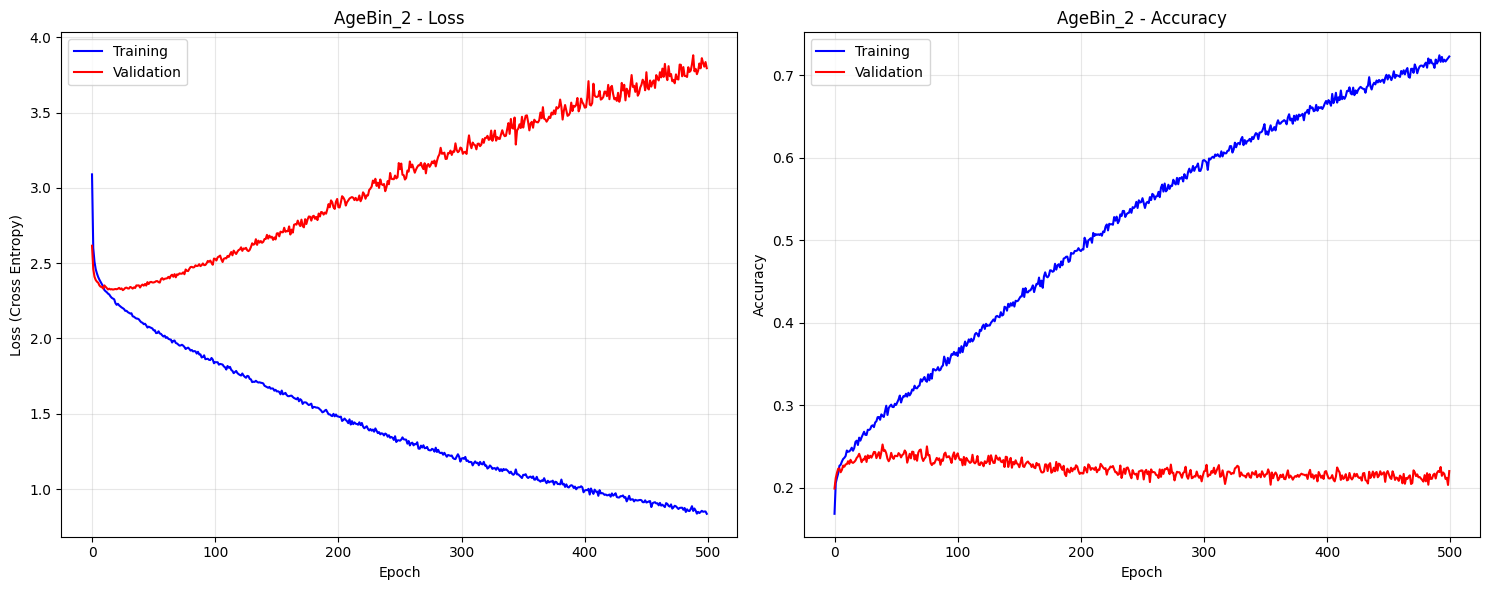

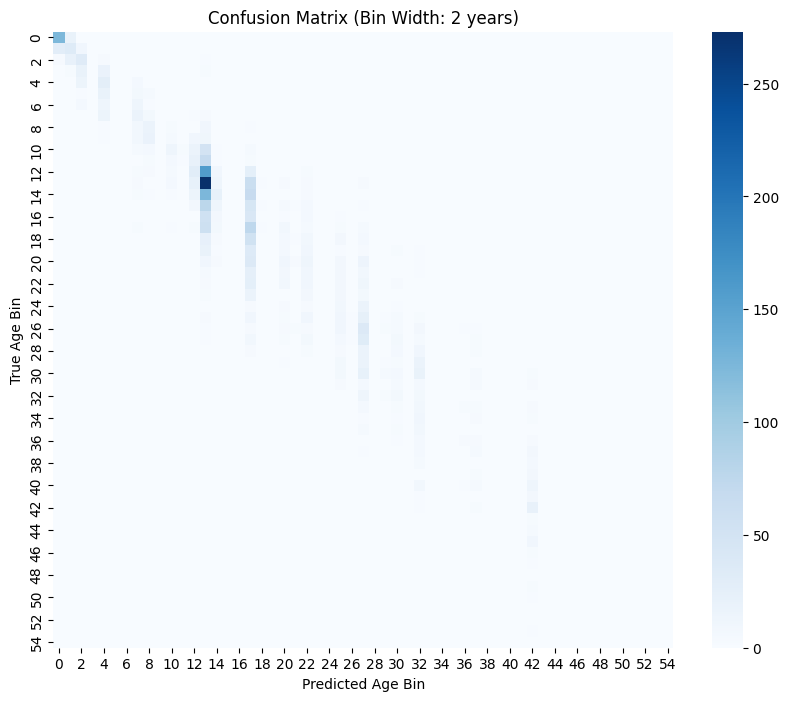

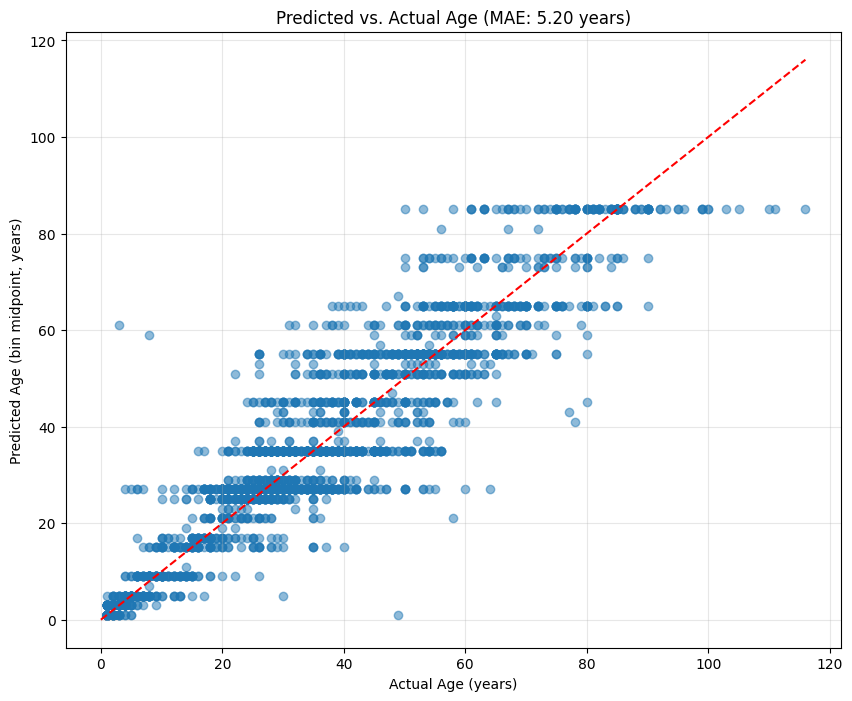


Evaluation Metrics for AgeBin_2 (Bin Width: 2 years):
Classification Accuracy: 0.2265
Mean Absolute Error (years): 5.20
Mean Bins Off: 2.56
Median Bins Off: 2.00

Training with bin width: 5 years
Training AgeBin_5...
Saved new best model with validation loss: 1.6903
Saved new best model with validation loss: 1.6099
Saved new best model with validation loss: 1.5795
Saved new best model with validation loss: 1.5571
Saved new best model with validation loss: 1.5558
Saved new best model with validation loss: 1.5278
Saved new best model with validation loss: 1.5175
Saved new best model with validation loss: 1.5151
Epoch 10/500, Train Loss: 1.5079, Train Acc: 0.4156, Val Loss: 1.5179, Val Acc: 0.4078
Saved new best model with validation loss: 1.5114
Saved new best model with validation loss: 1.5083
Saved new best model with validation loss: 1.5076
Epoch 20/500, Train Loss: 1.4284, Train Acc: 0.4411, Val Loss: 1.5112, Val Acc: 0.4159
Saved new best model with validation loss: 1.5045
Epoch 30

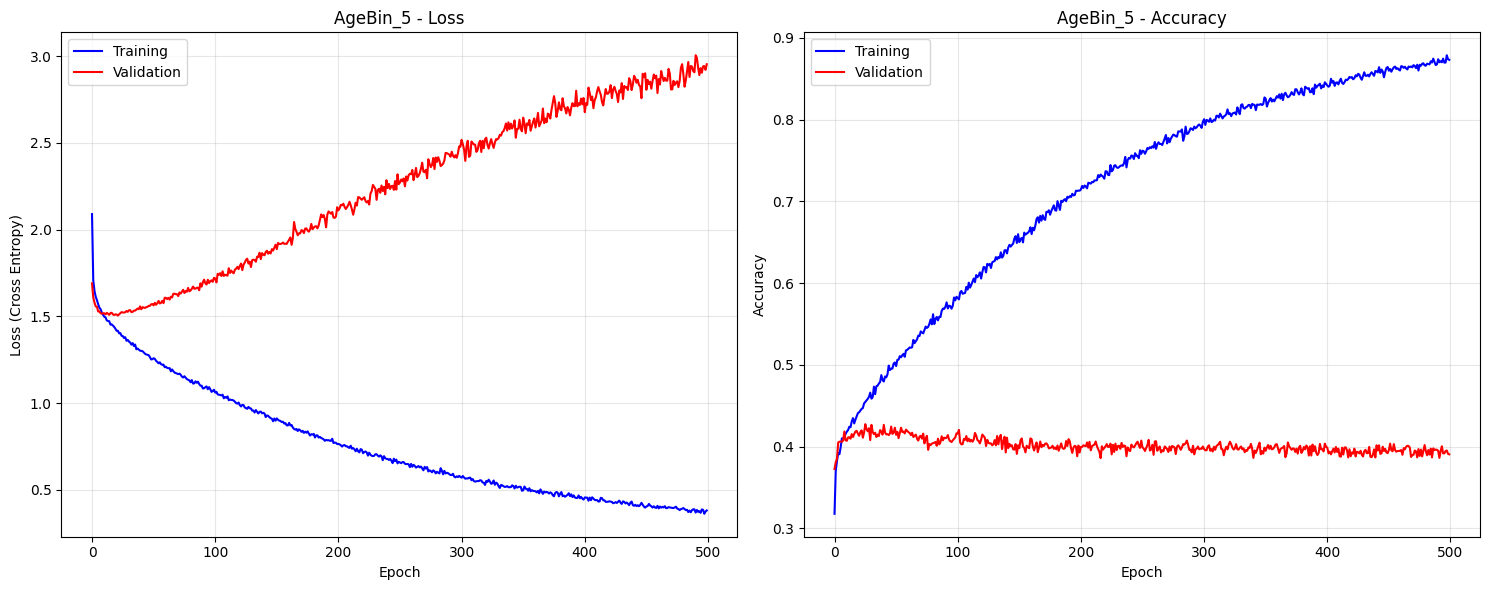

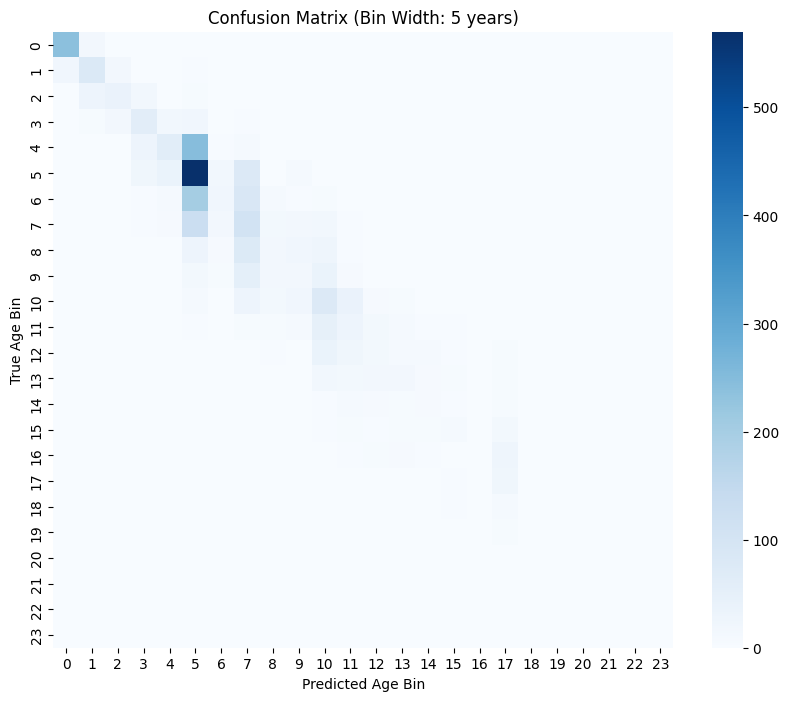

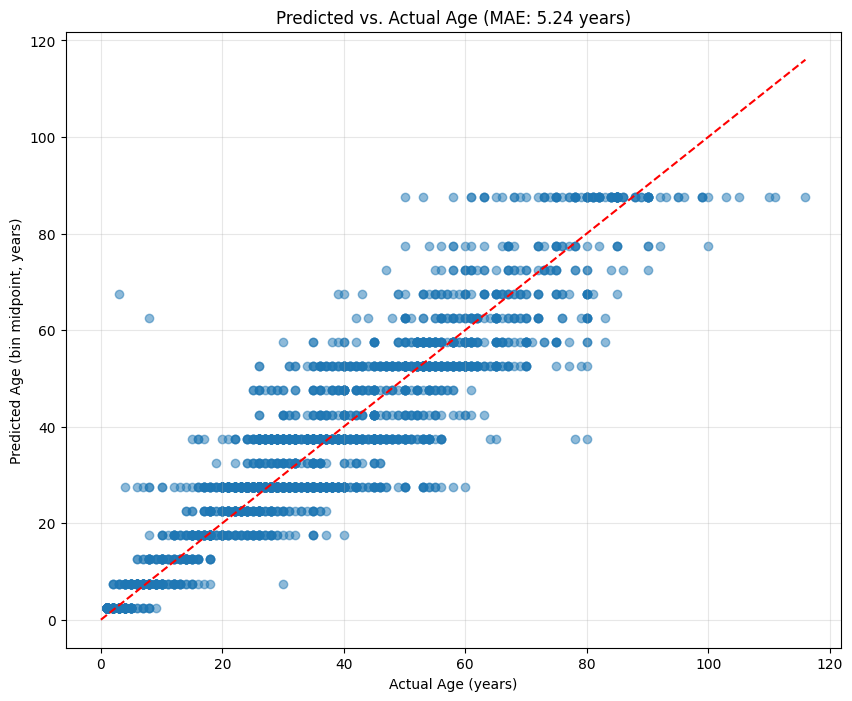


Evaluation Metrics for AgeBin_5 (Bin Width: 5 years):
Classification Accuracy: 0.4061
Mean Absolute Error (years): 5.24
Mean Bins Off: 1.01
Median Bins Off: 1.00

Training with bin width: 10 years
Training AgeBin_10...
Saved new best model with validation loss: 1.0544
Saved new best model with validation loss: 1.0030
Saved new best model with validation loss: 0.9890
Saved new best model with validation loss: 0.9771
Saved new best model with validation loss: 0.9719
Saved new best model with validation loss: 0.9571
Saved new best model with validation loss: 0.9571
Saved new best model with validation loss: 0.9551
Saved new best model with validation loss: 0.9480
Epoch 10/500, Train Loss: 0.9341, Train Acc: 0.6096, Val Loss: 0.9482, Val Acc: 0.6033
Saved new best model with validation loss: 0.9427
Epoch 20/500, Train Loss: 0.8647, Train Acc: 0.6399, Val Loss: 0.9522, Val Acc: 0.6123
Epoch 30/500, Train Loss: 0.8099, Train Acc: 0.6580, Val Loss: 0.9673, Val Acc: 0.6099
Epoch 40/500, Train

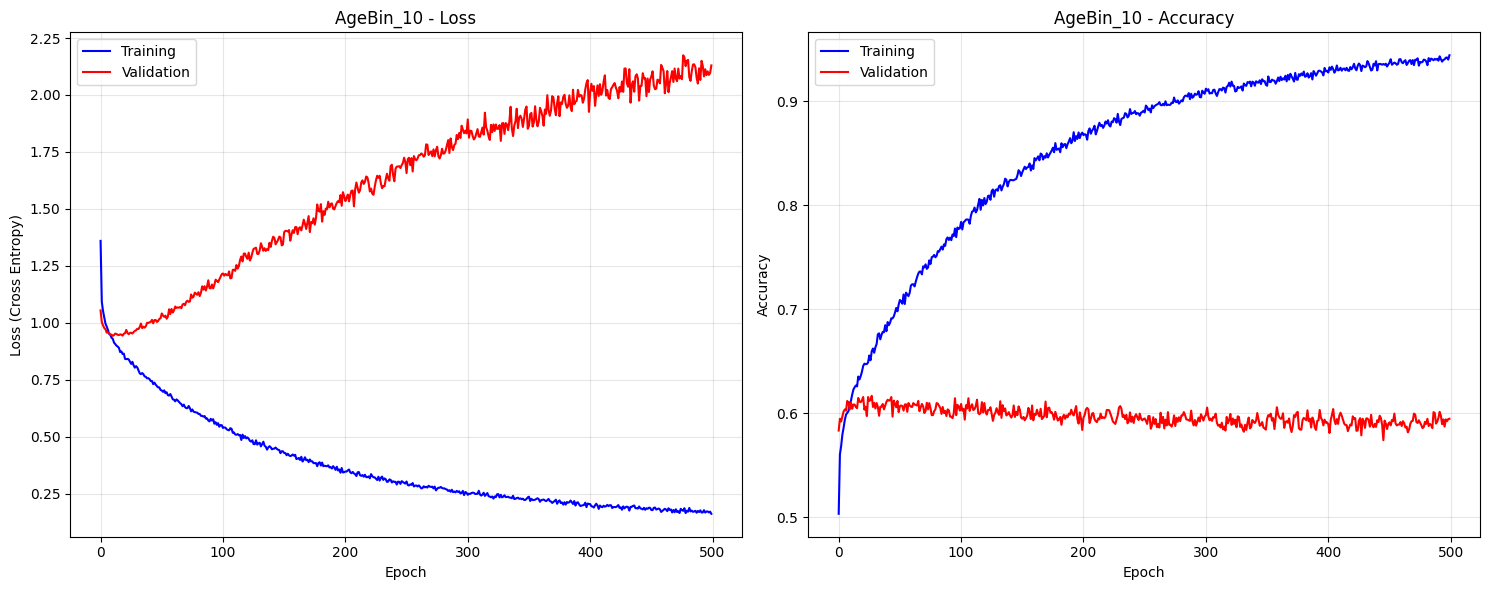

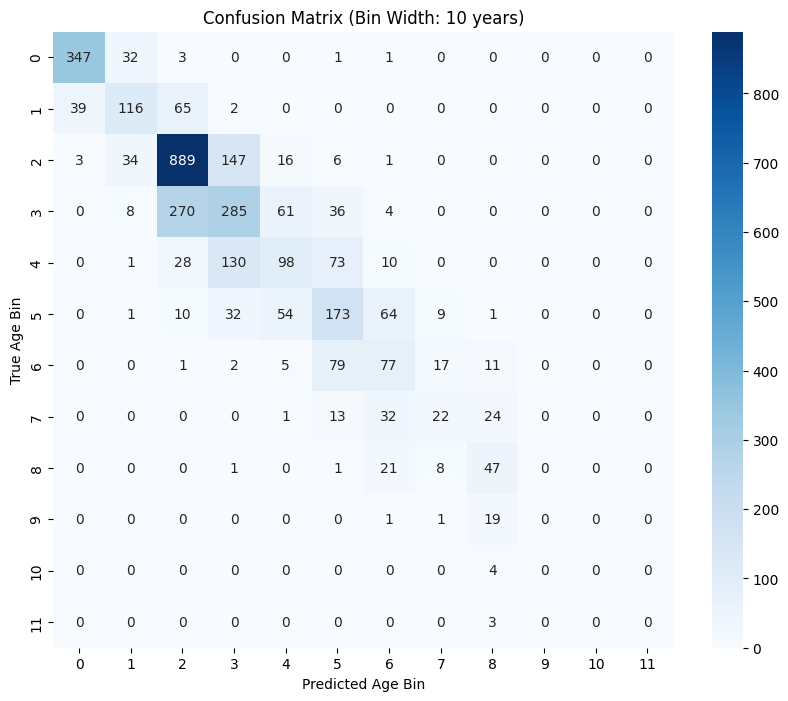

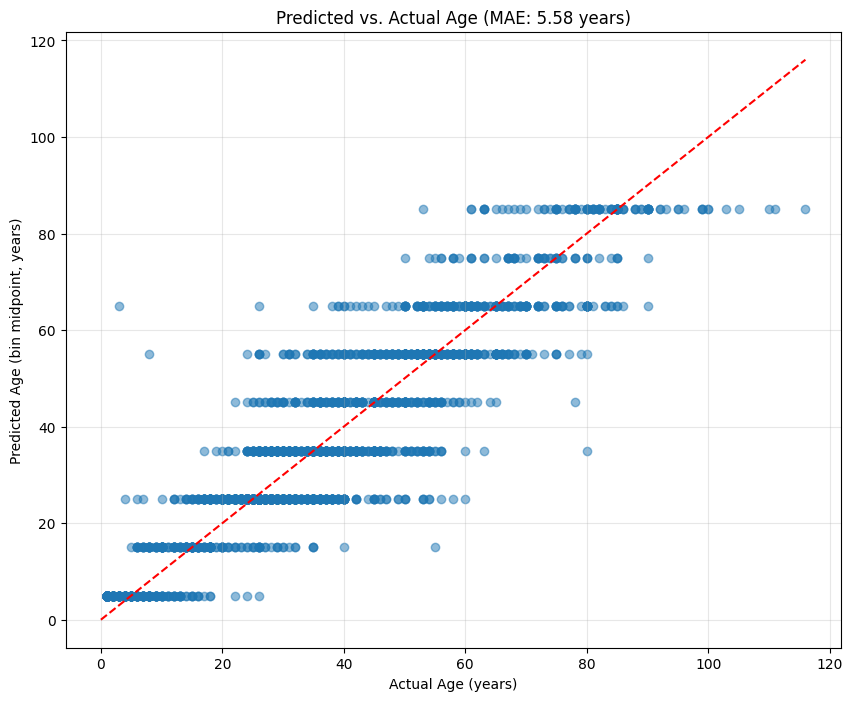


Evaluation Metrics for AgeBin_10 (Bin Width: 10 years):
Classification Accuracy: 0.5971
Mean Absolute Error (years): 5.58
Mean Bins Off: 0.49
Median Bins Off: 0.00


<Figure size 1000x600 with 0 Axes>

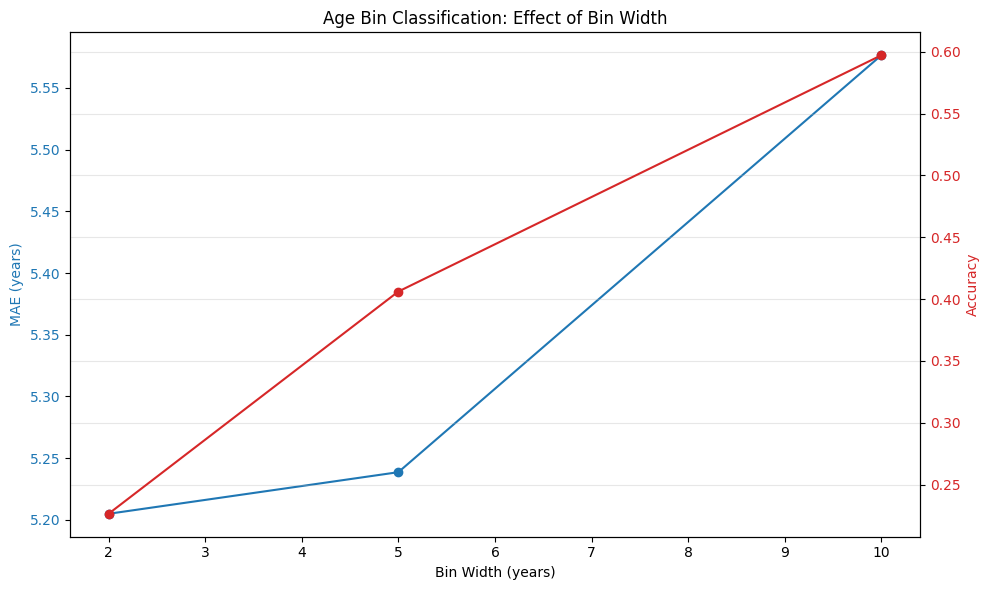


Bin Width Comparison Summary:
Bin Width  Accuracy   MAE (years)     Mean Bins Off  
--------------------------------------------------
2          0.2265     5.20           2.56
5          0.4061     5.24           1.01
10         0.5971     5.58           0.49


In [27]:
# Compare different bin widths
bin_comparison = compare_bin_widths(
    n_features=num_features,
    train_embeddings=train_embeddings,
    train_ages=train_ages,
    train_filenames=train_filenames,
    valid_embeddings=valid_embeddings,
    valid_ages=valid_ages,
    valid_filenames=valid_filenames,
    test_embeddings=test_embeddings,
    test_ages=test_ages,
    test_filenames=test_filenames,
    device=device,
    result_folder=result_folder,
    bin_widths=[2, 5, 10],  # Try different bin widths
    epochs=500,
    batch_size=batch_size
)

### Comparing Age Prediction Approaches: Regression vs. Classification

#### Introduction

For the task of age prediction from facial embeddings, we've explored two fundamentally different approaches:

1. **Regression**: Directly predicting age as a continuous value
2. **Classification**: Predicting age bins (e.g., 0-4, 5-9, 10-14, etc.)


#### Performance Metrics

##### Regression Approach
- **MAE**: Approx. 5 years (Mean Absolute Error)
- **RMSE**: Approx. 7 years (Root Mean Squared Error)
- **Advantages**: Direct age prediction, no discretization error
- **Challenges**: Difficulty with extreme ages, continuous errors

##### Classification Approach
- **Accuracy**: 40-60% (depending on bin width)
- **MAE**: 4-6 years (when converting bins back to ages using midpoints)
- **Mean Bins Off**: 0.5-2.6 (average distance in bins from true bin) (results depends on bin width)
- **Advantages**: Better at capturing age groups, more robust to outliers
- **Challenges**: Discretization error, bin boundary effects

#### Key Findings

1. **Bin Width Impact**:

We see that get better accuracy with large bin width, which is to be expected; meanwhile, the better loss is obtained by the smallest bin size.

2. **Error Distribution**:
   - Classification approach shows more symmetric error distribution
   - Regression approach tends to have longer tails (more extreme errors)

3. **Age-Specific Performance**:
   - Both approaches struggle with older ages (>70 years)
   - Classification more robust for under-represented age groups
   - Regression more accurate for well-represented middle ages (20-50)

Overall, the regression is better (lower loss across runs) and requires less hyperparameter tuning.

4. **Model Architecture Effects**:
   - RegularizedClassifier consistently performs best for classification
   - Regularization (dropout and batch normalization) benefits both approaches
   - Classification models converge faster during training

#### Visualizing the Differences

The confusion matrix for classification reveals interesting patterns:
- Strong diagonal indicating good performance (in particular for the larger bin width)
- Most errors occur in adjacent bins
- Some systematic confusion for certain age ranges

The scatter plots comparing predicted vs. actual ages show:
- Classification produces more "quantized" predictions
- Regression has smoother distribution but more outliers

#### Practical Considerations

When to choose each approach:

##### Use Classification When:
- Exact age is less important than age group
- Application needs interpretable confidence scores
- Dataset has imbalanced age distribution
- Robustness to outliers is critical

##### Use Regression When:
- Precise age prediction is required
- Dataset is large and well-balanced
- Application needs continuous values
- Performance for middle-age range is most important

#### Conclusion

Both approaches achieve similar overall performance (MAE of ~5 years), but with different error characteristics. The optimal choice depends on the specific application requirements.

For general-purpose age estimation from facial embeddings, a hybrid approach might be best: using classification for broad age groups, followed by regression within each group. This combines the robustness of classification with the precision of regression.

This comparative analysis demonstrates the value of exploring multiple approaches to the same problem, revealing insights that wouldn't be apparent from evaluating a single method alone.